# Imports

In [1]:
import sys
import os
from pathlib import Path

current_dir = os.getcwd()

file = Path(current_dir).resolve()
sys.path.append(str(file.parents[0]))
sys.path.append(str(file.parents[1]))
sys.path.append(str(file.parents[2]))

In [2]:
import scipy.ndimage
import torch.nn.functional as F
import monai
from skimage.measure import find_contours
import cv2
import numpy as np
import torch
import TPTBox
from TPTBox import NII, np_utils
from utils.brats_tools import get_central_slice, plot_slices, soften_gt
import utils.fastnumpyio.fastnumpyio as fnio
from data.bids_dataset import create_bids_path_list_of_dicts
import matplotlib.pyplot as plt
from scipy.ndimage import binary_dilation

In [3]:
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/'

train_list = create_bids_path_list_of_dicts(data_dir + '/train', suffix = 'fnio')

#  Function that plots all slices

In [4]:
def plot_all_slices(seg_mask:np.ndarray):
    for i in range(seg_mask.shape[0]):
        channel = seg_mask[i]

        xy_seg_slice = get_central_slice(channel, axis = 2)
        xz_seg_slice = get_central_slice(channel, axis = 1)
        yz_seg_slice = get_central_slice(channel, axis = 0)

        #plot all three next to each other
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))
        ax[0].imshow(xy_seg_slice)
        ax[0].set_title('XY plane')
        ax[1].imshow(xz_seg_slice)
        ax[1].set_title('XZ plane')
        ax[2].imshow(yz_seg_slice)
        ax[2].set_title('YZ plane')

# Test Gaussian Filter

### Test Conversions to Soft Mask in a binary scenario

#### Create a sample seg

In [5]:
# Define the dimensions
x, y, z = 200, 200 , 200  # Replace with your desired dimensions

# Create a tensor filled with zeros
circle_tensor = torch.zeros((x, y, z), dtype=torch.long)

# Define the radius of the circle (let's assume a radius of 20)
radius = 50

# Calculate the center of the tensor
center_x, center_y, center_z = x // 2, y // 2, z // 2

# Generate a meshgrid to calculate the distance from the center
X, Y, Z = torch.meshgrid(torch.arange(x), torch.arange(y), torch.arange(z))

# Calculate the distance from the center for each point
distance = torch.sqrt((X - center_x)**2 + (Y - center_y)**2 + (Z - center_z)**2)

# Set ones inside the circle (where the distance is less than the radius)
circle_tensor[distance <= radius] = 1

#One-hot encode the sample segmentation and permute the dimensions
oh_tensor = F.one_hot(circle_tensor, num_classes=2).permute(3, 0, 1, 2)

####################################
/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 739, in start
    self.io_loop.s

##### Plotting

Text(0.5, 0.98, 'With One-Hot')

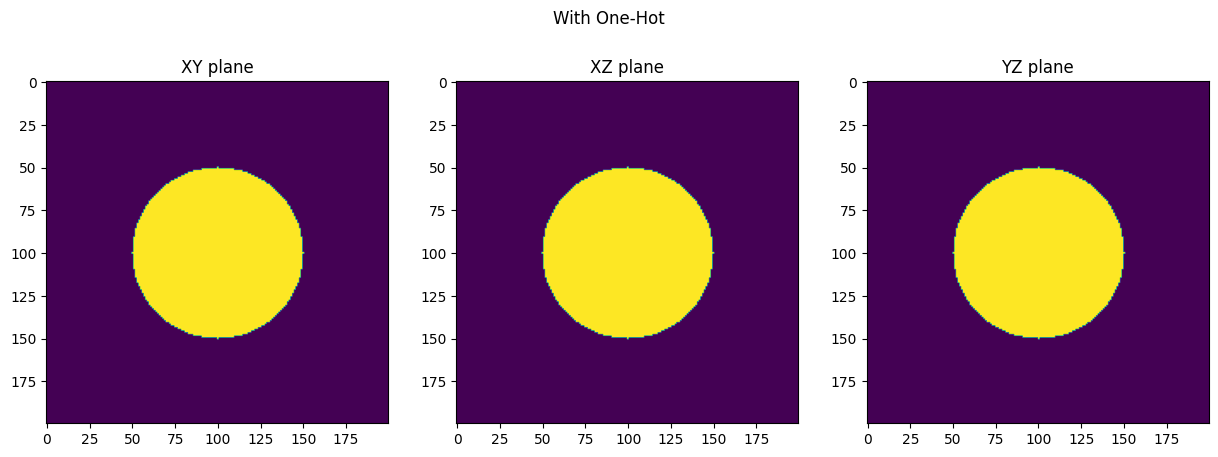

In [6]:
# plot the one-hot encoded map
xy_slice = get_central_slice(oh_tensor, axis = 2)
xz_slice = get_central_slice(oh_tensor, axis = 1)
yz_slice = get_central_slice(oh_tensor, axis = 0)
xy_class_map = torch.argmax(xy_slice, dim=0)    # dim 0 is the label channel
xz_class_map = torch.argmax(xz_slice, dim=0)    # dim 0 is the label channel
yz_class_map = torch.argmax(yz_slice, dim=0)    # dim 0 is the label channel
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_class_map)
ax[0].set_title('XY plane')
ax[1].imshow(xz_class_map)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_class_map)
ax[2].set_title('YZ plane')
plt.suptitle('With One-Hot')

#### Try a Gaussian Filter on one-hot encoded

##### Create and apply filter

In [7]:
# Define the standard deviation (sigma) for the Gaussian filter
sigma = 0.2  # You can adjust the sigma value

# Apply Gaussian filter to each channel
filtered_oh_tensor = torch.empty_like(oh_tensor, dtype=torch.float32)  # Create an empty tensor to store the results

for i in range(oh_tensor.shape[0]):  # Loop through each class channel
    filtered_oh_tensor[i] = torch.tensor(scipy.ndimage.gaussian_filter(oh_tensor[i].numpy().astype(float), sigma=sigma))


print(filtered_oh_tensor.shape)  # Should still be (2, x, y, z)
print(filtered_oh_tensor)
print(f"np.unique(filtered_tensor): {np.unique(filtered_oh_tensor)}")
print(f"np.unique(one_hot_tensor): {np.unique(oh_tensor)}")
print(f"filtered_oh_tensor[:,7,15,10]: {filtered_oh_tensor[:,7,15,10]}")

torch.Size([2, 200, 200, 200])
tensor([[[[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.]],

         ...,

         [[1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          [1., 1., 1.,  ..., 1., 1., 1.],
          ...,
      

##### Plot slices channelwise, to visualize the "probablities' of each class

Text(0.5, 1.0, 'YZ plane')

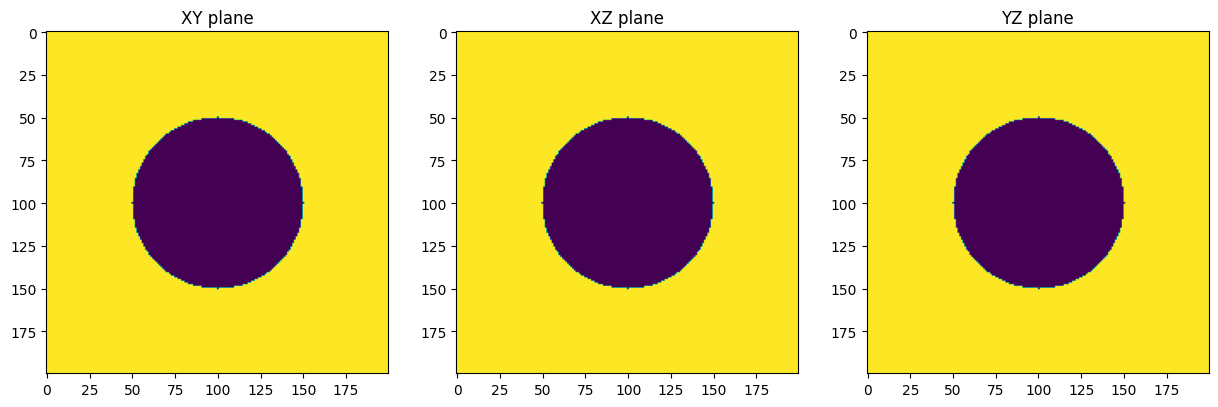

In [8]:
first_channel = filtered_oh_tensor[0]

xy_slice = get_central_slice(first_channel, axis = 2)
xz_slice = get_central_slice(first_channel, axis = 1)
yz_slice = get_central_slice(first_channel, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

Text(0.5, 1.0, 'YZ plane')

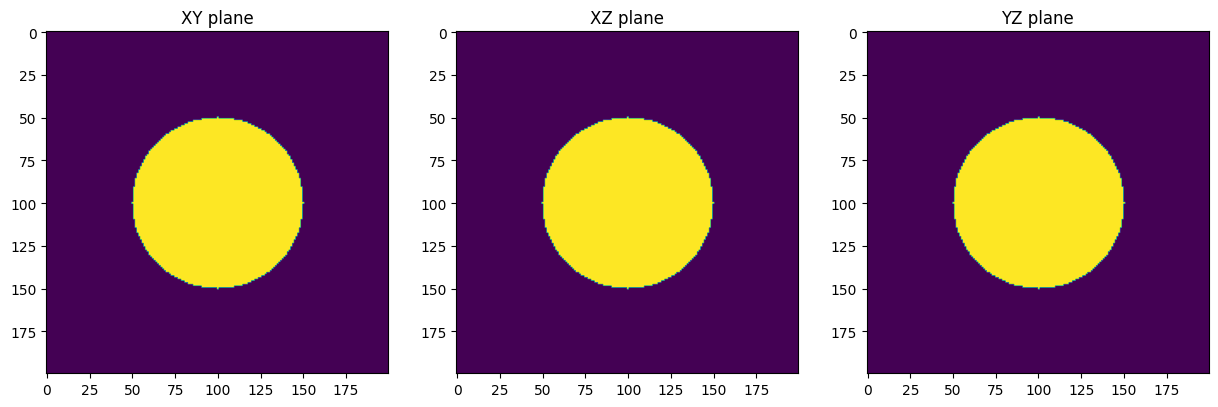

In [9]:
sec_channel = filtered_oh_tensor[1]

xy_slice = get_central_slice(sec_channel, axis = 2)
xz_slice = get_central_slice(sec_channel, axis = 1)
yz_slice = get_central_slice(sec_channel, axis = 0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_slice)
ax[0].set_title('XY plane')
ax[1].imshow(xz_slice)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_slice)
ax[2].set_title('YZ plane')

#### Compare softened and original GTs

Plot both next to each other

Text(0.5, 0.98, 'Side by Side')

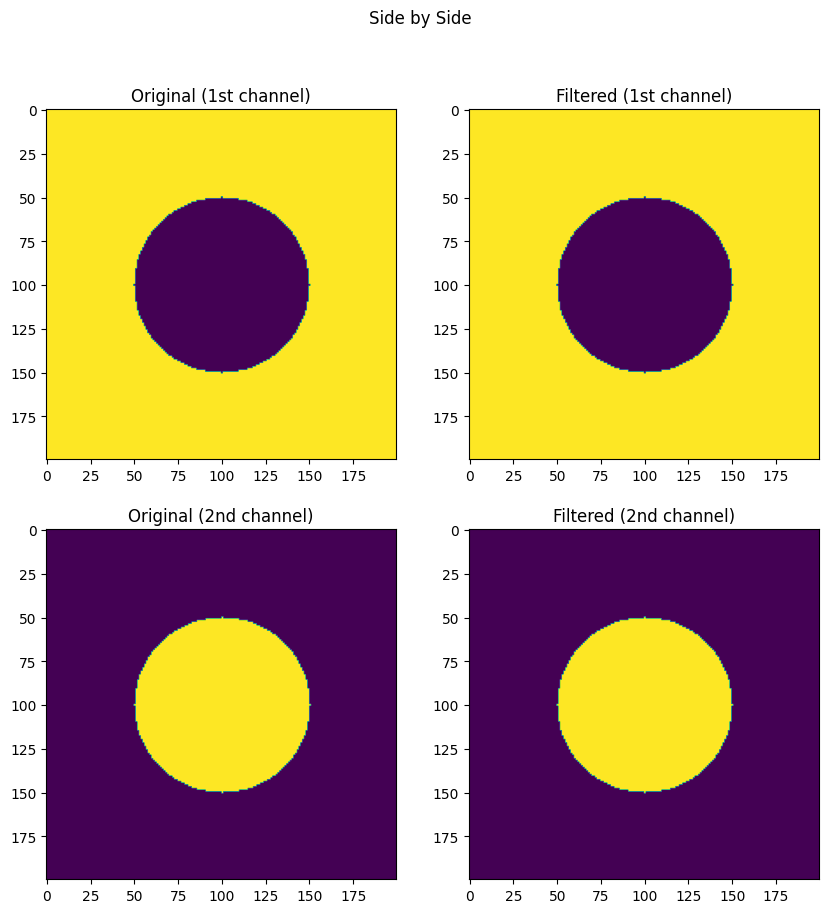

In [10]:
# get central slices for GTs of first channel
original_slice_first_channel = get_central_slice(oh_tensor[0], axis = 2)
original_slice_sec_channel = get_central_slice(oh_tensor[1], axis = 2)
soft_slice_first_channel = get_central_slice(filtered_oh_tensor[0], axis = 2)
soft_slice_sec_channel = get_central_slice(filtered_oh_tensor[1], axis = 2)

fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].imshow(original_slice_first_channel)
ax[0, 0].set_title('Original (1st channel)')
ax[0, 1].imshow(soft_slice_first_channel)
ax[0, 1].set_title('Filtered (1st channel)')
ax[1, 0].imshow(original_slice_sec_channel)
ax[1, 0].set_title('Original (2nd channel)')
ax[1, 1].imshow(soft_slice_sec_channel)
ax[1, 1].set_title('Filtered (2nd channel)')
plt.suptitle('Side by Side')

Difference (First Channel)

Text(0.5, 0.98, 'Absolute Difference')

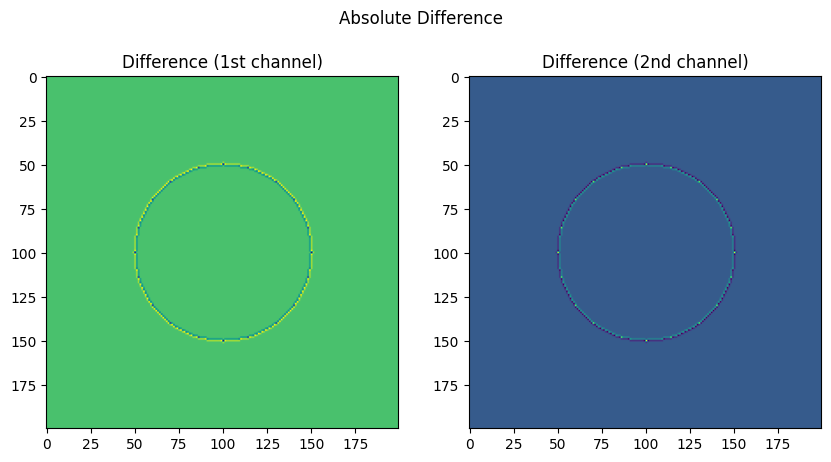

In [11]:
# get difference of both slices to see where they differ
diff_first_channel = original_slice_first_channel - soft_slice_first_channel
diff_sec_channel = original_slice_sec_channel - soft_slice_sec_channel
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(diff_first_channel)
ax[0].set_title('Difference (1st channel)')
ax[1].imshow(diff_sec_channel)
ax[1].set_title('Difference (2nd channel)')
plt.suptitle('Absolute Difference')

Text(0.5, 0.98, 'Absolute Difference')

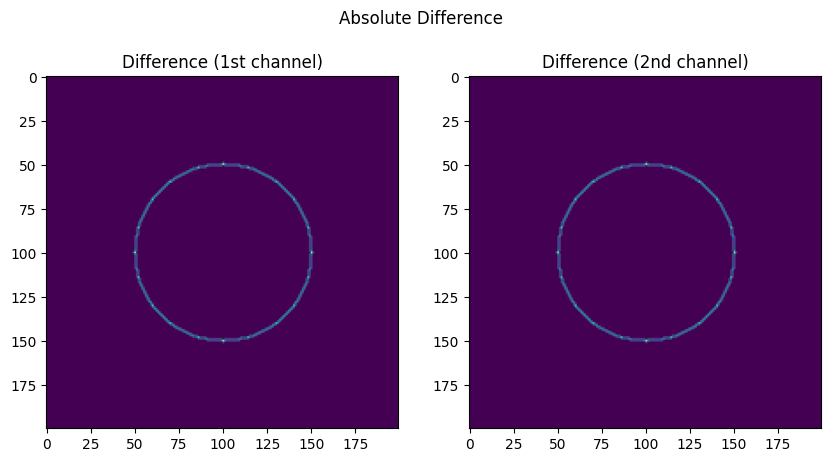

In [12]:
# get difference of both slices to see where they differ
diff_first_channel = np.abs(original_slice_first_channel - soft_slice_first_channel)
diff_sec_channel = np.abs(original_slice_sec_channel - soft_slice_sec_channel)
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(diff_first_channel)
ax[0].set_title('Difference (1st channel)')
ax[1].imshow(diff_sec_channel)
ax[1].set_title('Difference (2nd channel)')
plt.suptitle('Absolute Difference')

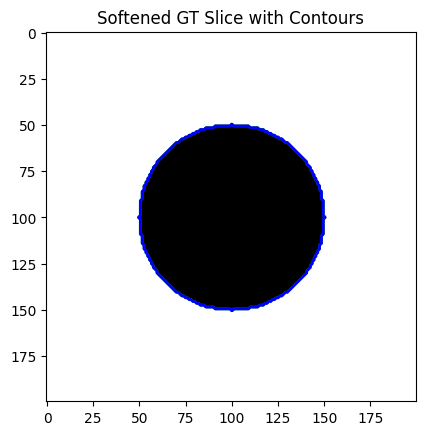

In [13]:
# Find contours for original and softened GT slices
contours_gt_slice = find_contours(original_slice_first_channel.numpy(), level=0.5)
contours_softened_slice = find_contours(soft_slice_first_channel.numpy(), level=0.5)

# Plot the softened GT slice with contours
plt.title("Softened GT Slice with Contours")
plt.imshow(soft_slice_first_channel, cmap='gray')
for contour in contours_gt_slice:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='green')
for contour in contours_softened_slice:
    plt.plot(contour[:, 1], contour[:, 0], linewidth=2, color='blue')

plt.show()

### Test softening with multi classes

#### Create sample seg with 4 classes

In [14]:
# Define the dimensions
x, y, z = 100, 100 , 100  # Replace with your desired dimensions

# Create a tensor filled with zeros
circle_tensor = torch.zeros((x, y, z), dtype=torch.long)

# Define the radius' of the circles (let's assume a radius of 20)
radius_c3 = 5
radius_c2 = 20
radius_c1 = 40

# Calculate the center of the tensor
center_x, center_y, center_z = x // 2, y // 2, z // 2

# Generate a meshgrid to calculate the distance from the center
X, Y, Z = torch.meshgrid(torch.arange(x), torch.arange(y), torch.arange(z))

# Calculate the distance from the center for each point
distance = torch.sqrt((X - center_x)**2 + (Y - center_y)**2 + (Z - center_z)**2)

# Set ones inside the circle (where the distance is less than the radius)
circle_tensor[distance <= radius_c1] = 1
circle_tensor[distance <= radius_c2] = 2
circle_tensor[distance <= radius_c3] = 3

print(f"circle_tensor.shape: {circle_tensor.shape}")  # Should be (x,y,z)
print(f"np.unique(circle_tensor): {np.unique(circle_tensor)}")

#One-hot encode the sample segmentation
oh_tensor = F.one_hot(circle_tensor, num_classes=4).permute(3, 0, 1, 2)

print(f"oh_tensor.shape: {oh_tensor.shape}")  # Should be (4, x, y, z)
print(f"np.unique(oh_tensor): {np.unique(oh_tensor)}")

circle_tensor.shape: torch.Size([100, 100, 100])
np.unique(circle_tensor): [0 1 2 3]
oh_tensor.shape: torch.Size([4, 100, 100, 100])
np.unique(oh_tensor): [0 1]


##### Plot one-hot encoded

Text(0.5, 0.98, 'With One-Hot')

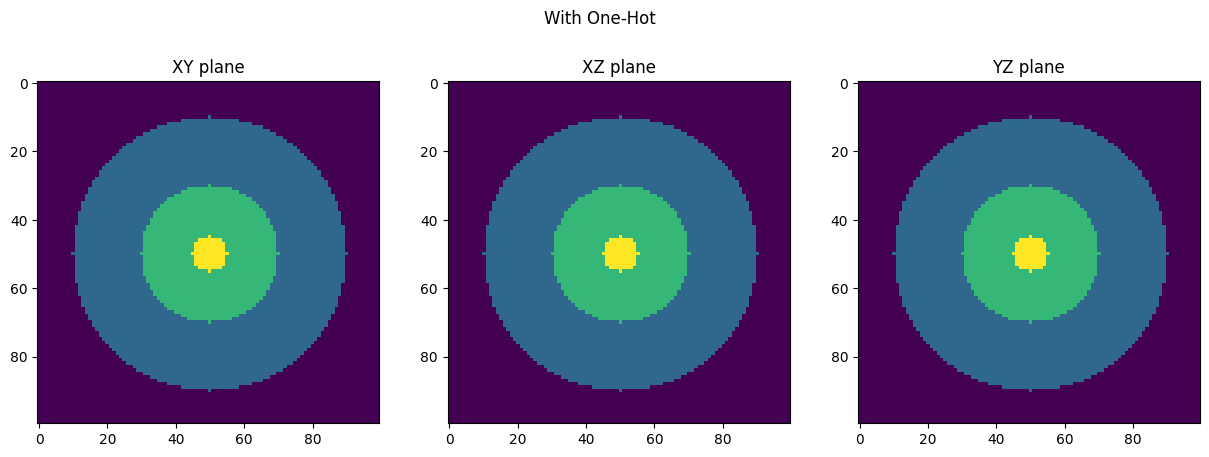

In [15]:
# plot the one-hot encoded map
xy_slice = get_central_slice(oh_tensor, axis = 2)
xz_slice = get_central_slice(oh_tensor, axis = 1)
yz_slice = get_central_slice(oh_tensor, axis = 0)
xy_class_map = torch.argmax(xy_slice, dim=0)
xz_class_map = torch.argmax(xz_slice, dim=0)
yz_class_map = torch.argmax(yz_slice, dim=0)
#plot all three next to each other
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(xy_class_map)
ax[0].set_title('XY plane')
ax[1].imshow(xz_class_map)
ax[1].set_title('XZ plane')
ax[2].imshow(yz_class_map)
ax[2].set_title('YZ plane')
plt.suptitle('With One-Hot')

#### Try Gaussian on multi-class one-hot

In [16]:
print(f"oh_tensor.shape: {oh_tensor.shape}")  # Should be (4, x, y, z)
print(f"np.unique(oh_tensor): {np.unique(oh_tensor)}")
print(f"oh_tensor: {oh_tensor}")

oh_tensor.shape: torch.Size([4, 100, 100, 100])
np.unique(oh_tensor): [0 1]
oh_tensor: tensor([[[[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1]],

         ...,

         [[1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
          ...,
          [1, 1, 1,  ..., 1, 1, 1],
          [1, 1, 1,  ..., 1, 1, 1],
    

In [17]:
# Define the standard deviation (sigma) for the Gaussian filter
sigma = 1  # You can adjust the sigma value

# Apply Gaussian filter to each channel
filtered_oh_tensor = torch.empty_like(oh_tensor, dtype=torch.float32)  # Create an empty tensor to store the results

for i in range(oh_tensor.shape[0]):  # Loop through each class channel
    filtered_oh_tensor[i] = torch.tensor(scipy.ndimage.gaussian_filter(oh_tensor[i].numpy().astype(float), sigma=sigma))


print(filtered_oh_tensor.shape)  # Should still be (4, x, y, z)
print(f"np.unique(filtered_tensor): {np.unique(filtered_oh_tensor)}")
print(f"np.unique(oh_tensor): {np.unique(oh_tensor)}")

torch.Size([4, 100, 100, 100])
np.unique(filtered_tensor): [0.0000000e+00 2.3969917e-12 4.7939834e-12 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]
np.unique(oh_tensor): [0 1]


##### Plot slices channelwise, to visualize the "probablities' of each class

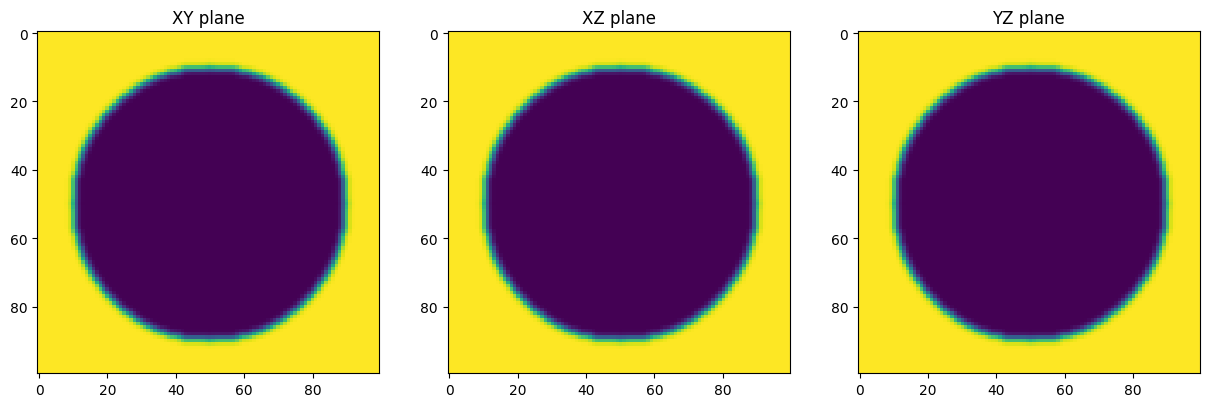

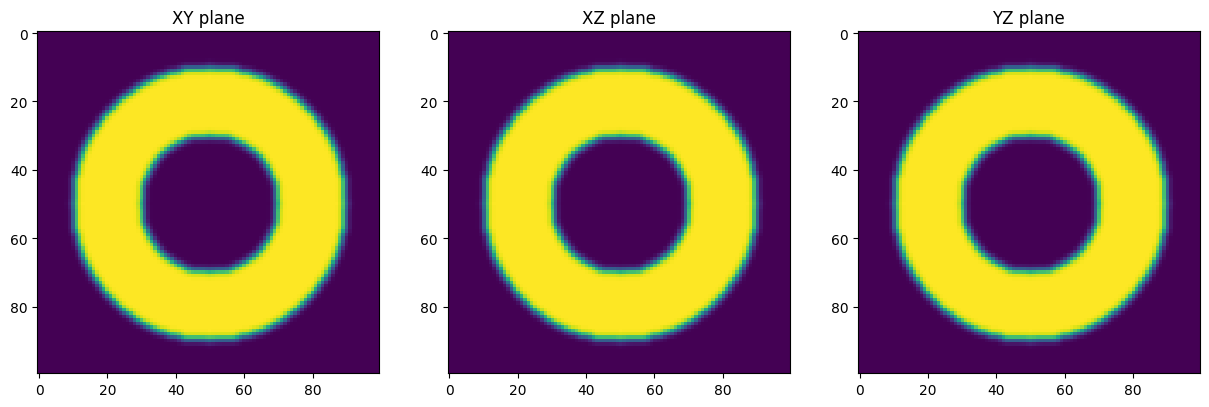

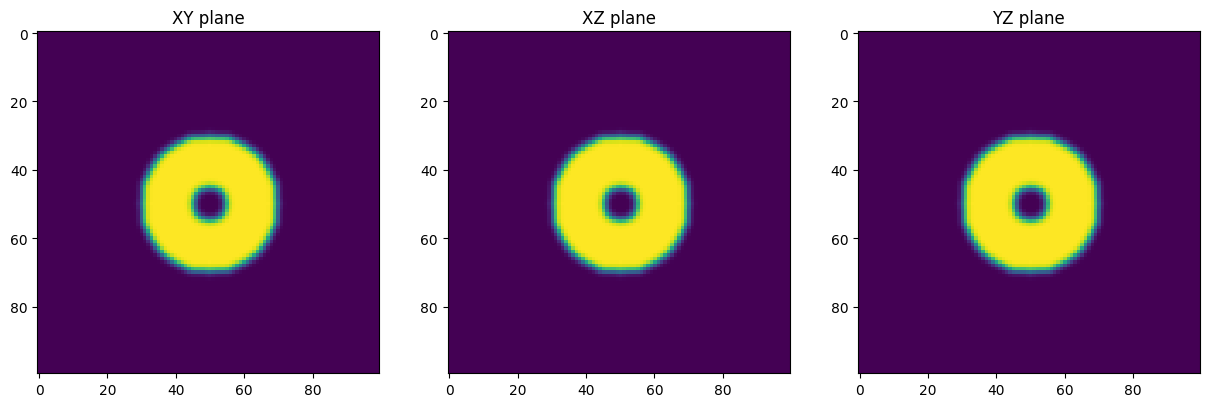

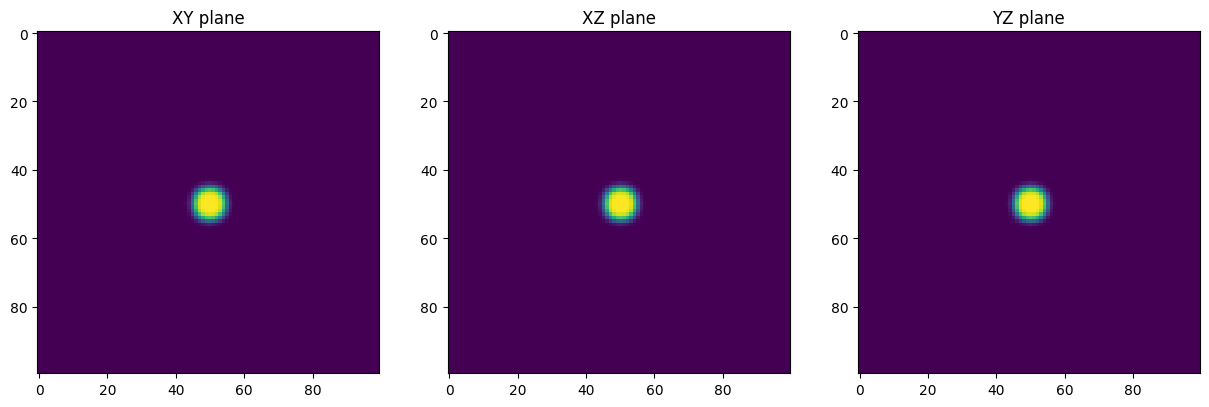

In [18]:
for i in range(filtered_oh_tensor.shape[0]):
    channel = filtered_oh_tensor[i]
    
    xy_slice = get_central_slice(channel, axis = 2)
    xz_slice = get_central_slice(channel, axis = 1)
    yz_slice = get_central_slice(channel, axis = 0)
    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_slice)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_slice)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_slice)
    ax[2].set_title('YZ plane')

### Test Softening on actual Ground Truth

In [19]:
#Loading actual data
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/'
train_list = create_bids_path_list_of_dicts(data_dir + '/train', suffix = 'fnio')

# 1. load image 
sample_idx = 3
img_path = train_list[sample_idx]['t1c']
seg_path = train_list[sample_idx]['seg']

img = fnio.load(str(img_path))
seg = fnio.load(str(seg_path))

# 2. transform to torch tensors (and add channel dim to img tensor)
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
seg_tensor = torch.tensor(seg, dtype=torch.long)

# 3. transform seg_tensor to one hot encoding and permute the dimensions
oh_seg = F.one_hot(seg_tensor, num_classes=4)
oh_seg = oh_seg.permute(3, 0, 1, 2)

In [20]:
# Define the standard deviation (sigma) for the Gaussian filter
sigma = 0.5  # You can adjust the sigma value

# Apply Gaussian filter to each channel
filtered_oh_seg = torch.empty_like(oh_seg, dtype=torch.float32)  # Create an empty tensor to store the results

for i in range(oh_seg.shape[0]):  # Loop through each class channel
    filtered_oh_seg[i] = torch.tensor(scipy.ndimage.gaussian_filter(oh_seg[i].numpy().astype(np.float32), sigma=sigma))


print(filtered_oh_seg.shape)  # Should still be (4, x, y, z)
print(f"np.unique(filtered_oh_seg): {np.unique(filtered_oh_seg)}")

torch.Size([4, 240, 240, 155])
np.unique(filtered_oh_seg): [0.0000000e+00 1.8371549e-11 3.6743098e-11 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]


#### Plots

In [21]:
xy_img_slice = get_central_slice(img_tensor, axis = 2)
xz_img_slice = get_central_slice(img_tensor, axis = 1)
yz_img_slice = get_central_slice(img_tensor, axis = 0)

unique values in channel 0: [0.0000000e+00 1.8371549e-11 3.6743098e-11 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]
unique values in channel 1: [0.0000000e+00 1.8371549e-11 3.6743098e-11 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]
unique values in channel 2: [0.0000000e+00 1.8371549e-11 3.6743098e-11 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]
unique values in channel 3: [0.0000000e+00 1.8371549e-11 3.6743098e-11 ... 9.9999988e-01 9.9999994e-01
 1.0000000e+00]


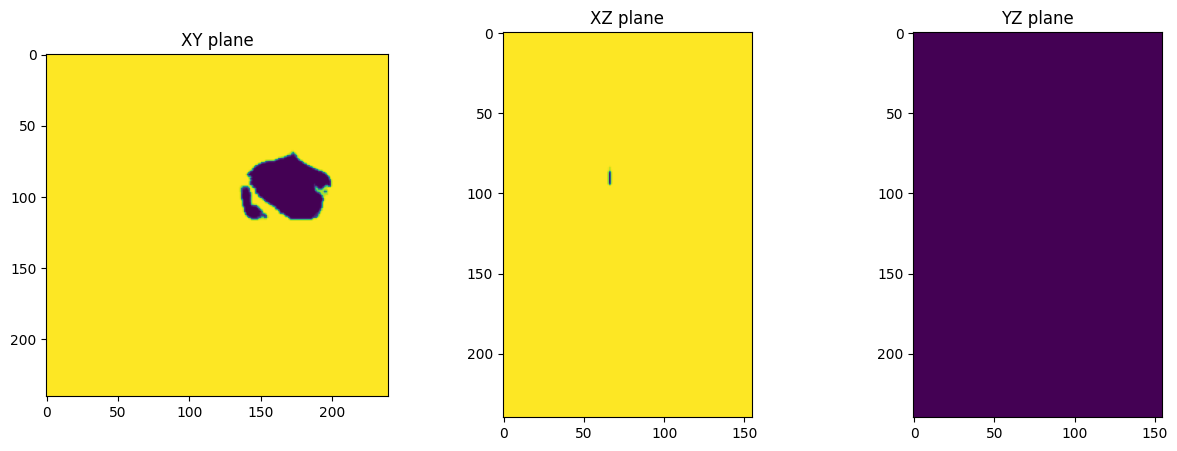

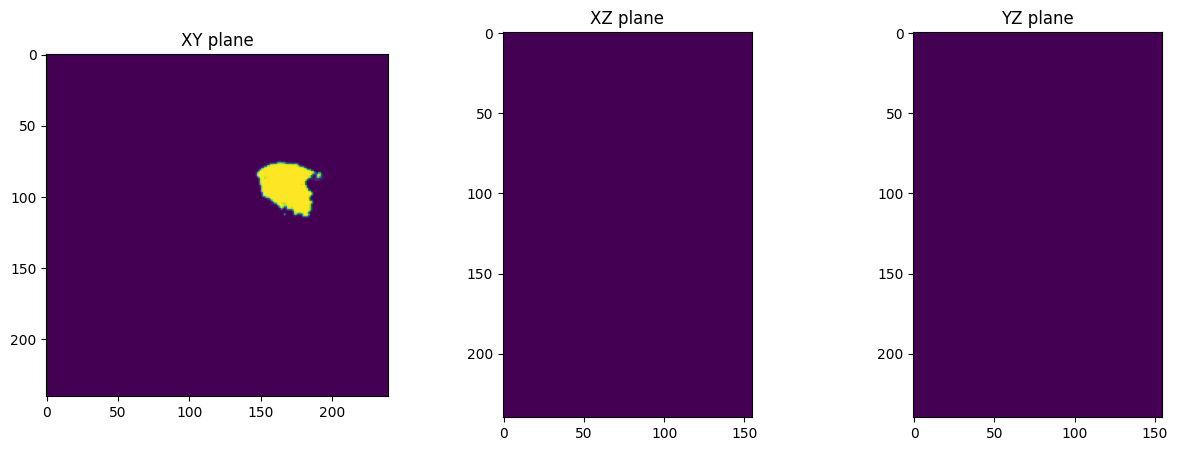

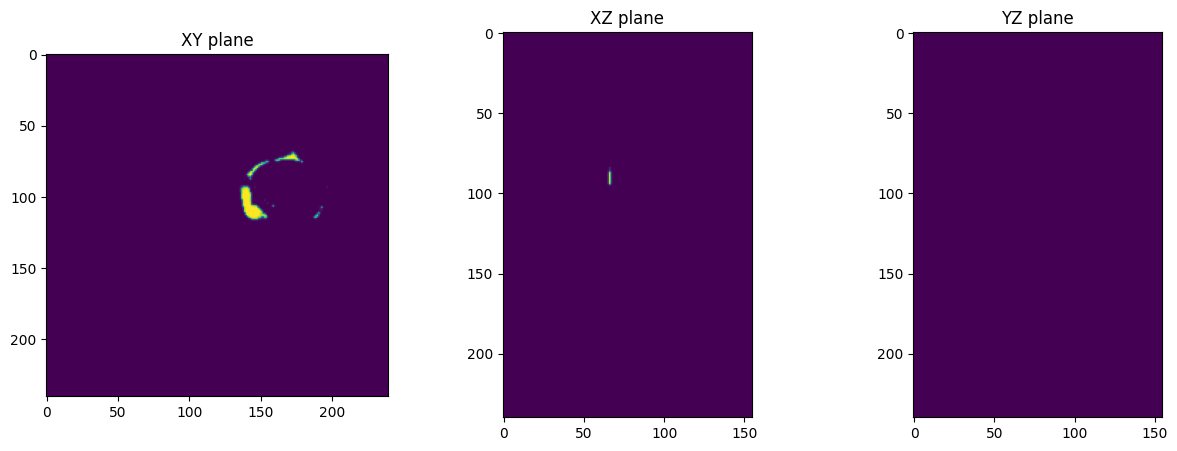

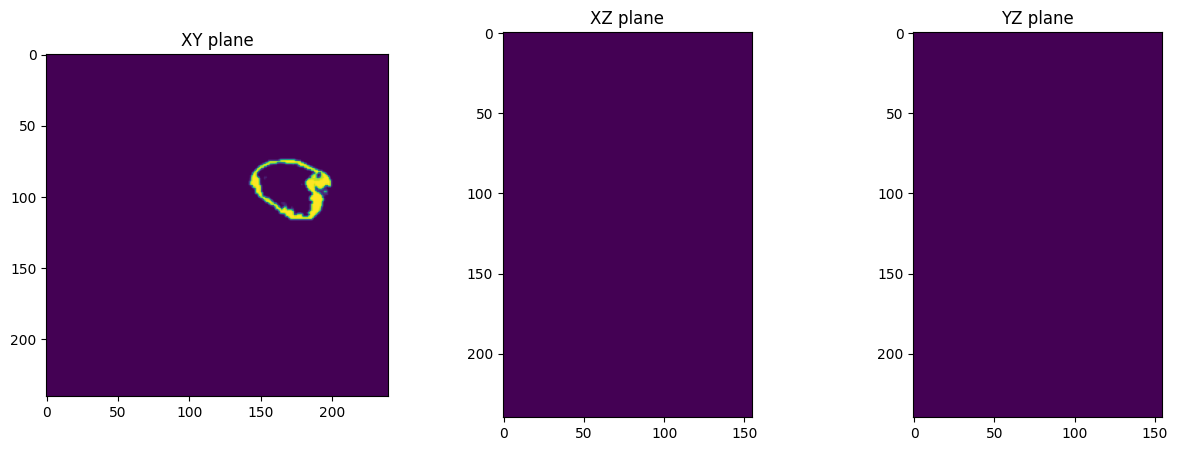

In [22]:
# Plot only segmentation masks
for i in range(filtered_oh_seg.shape[0]):
    channel = filtered_oh_seg[i]

    print(f"unique values in channel {i}: {np.unique(channel)}")

    xy_seg_slice = get_central_slice(channel, axis = 2)
    xz_seg_slice = get_central_slice(channel, axis = 1)
    yz_seg_slice = get_central_slice(channel, axis = 0)

    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_seg_slice)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_seg_slice)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_seg_slice)
    ax[2].set_title('YZ plane')

unique values in difference: [-0.49277568 -0.44730806 -0.42825025 ...  0.42699066  0.43815026
  0.5133538 ]
unique values in difference: [-0.5133538  -0.5133537  -0.5133507  ...  0.49521327  0.5029172
  0.51293284]
unique values in difference: [-0.5133538  -0.51335377 -0.5133537  ...  0.36352065  0.3722044
  0.40614593]
unique values in difference: [-0.51293284 -0.5029172  -0.49521327 ...  0.4472387   0.44728297
  0.44733006]


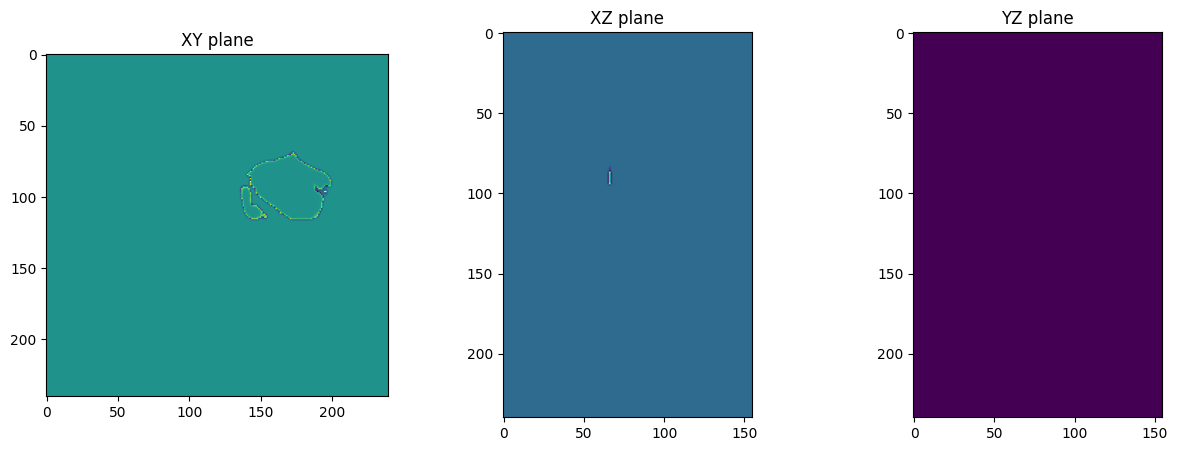

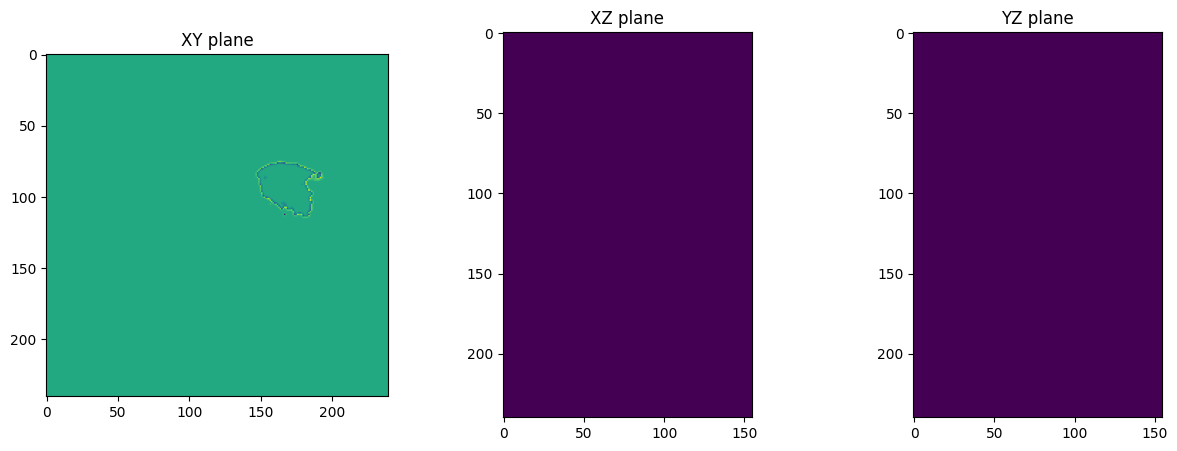

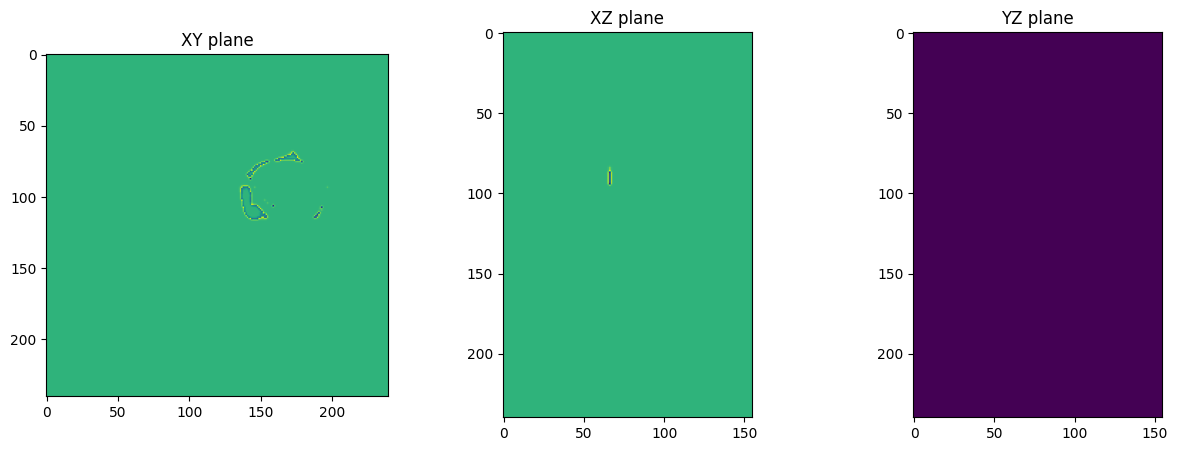

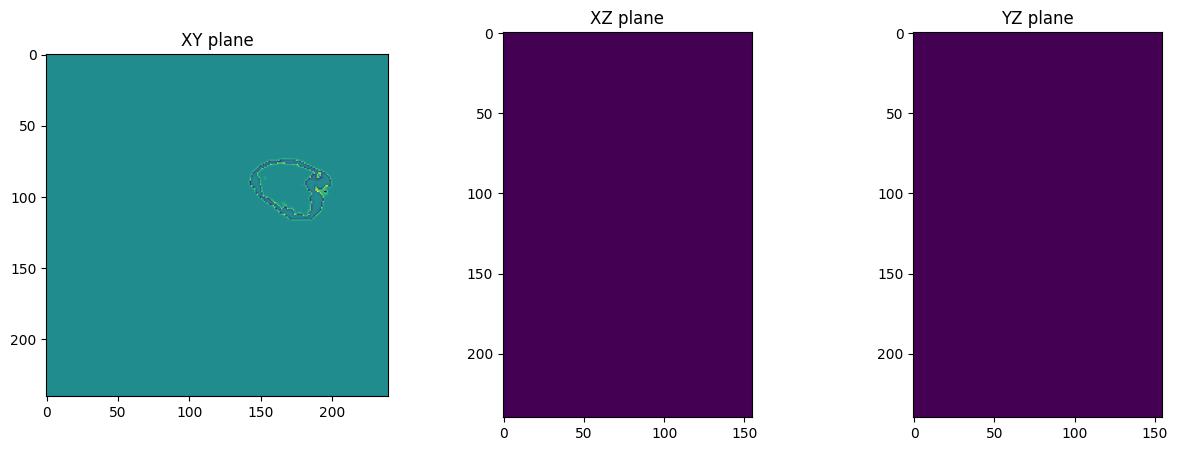

In [23]:
# Plot the difference between the original and the filtered segmentation masks
for i in range(filtered_oh_seg.shape[0]):
    channel = filtered_oh_seg[i]
    original_channel = oh_seg[i]

    difference = channel - original_channel

    print(f"unique values in difference: {np.unique(difference)}")

    xy_diff = get_central_slice(difference, axis = 2)
    xz_diff = get_central_slice(difference, axis = 1)
    yz_diff = get_central_slice(difference, axis = 0)

    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_diff)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_diff)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_diff)
    ax[2].set_title('YZ plane')

####################################
/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/src/utils/brats_tools.py:15: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608853085/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  ax[0].imshow(mri_slice.T, cmap=cmap_mri, origin='lower')
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/home/student/farid_ma/dev/multiclass_softseg/lib/python3.11/site-packages/traitlets/config/application.py", line 1075, in launch_ins

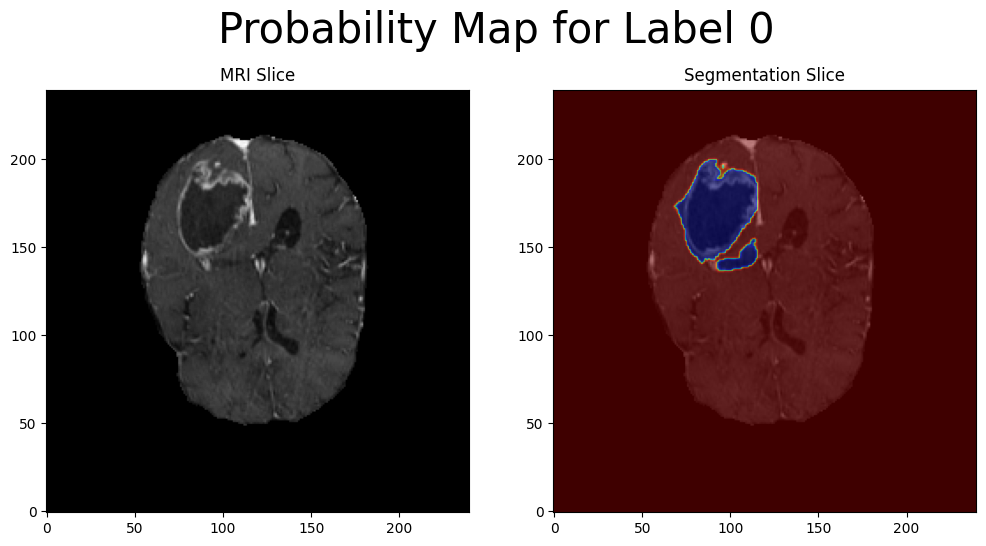

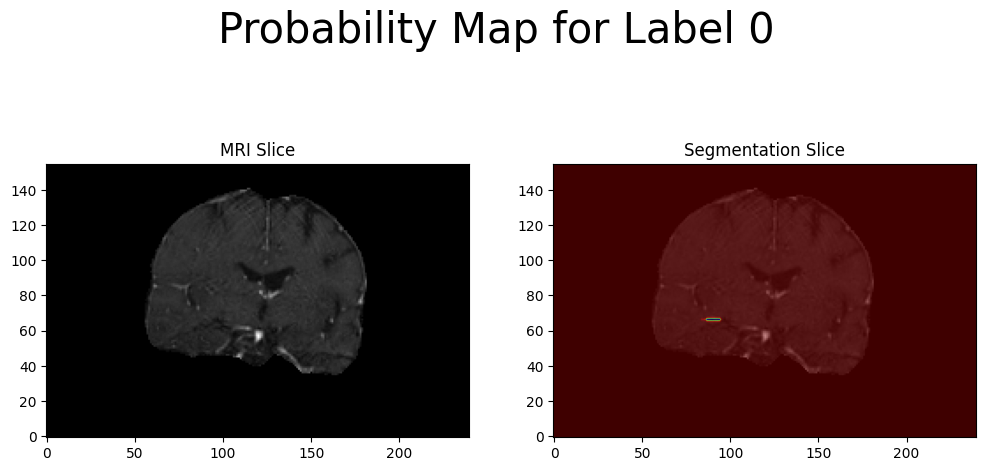

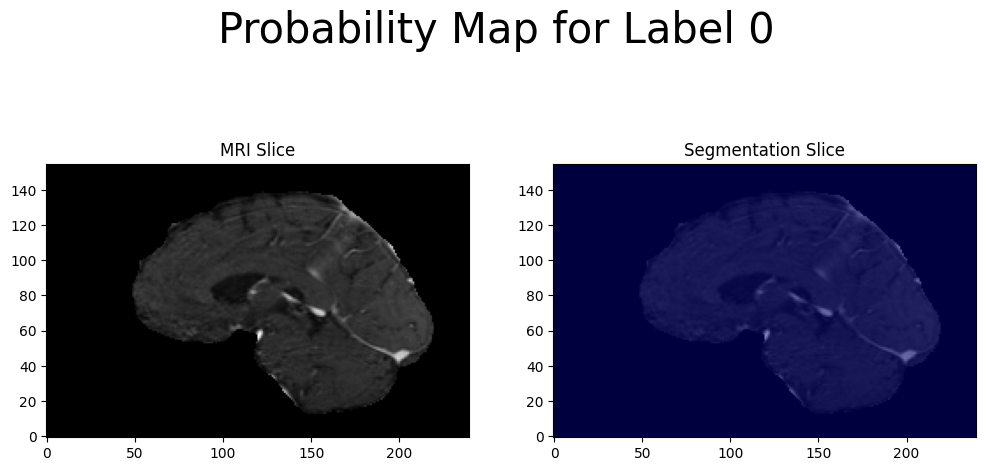

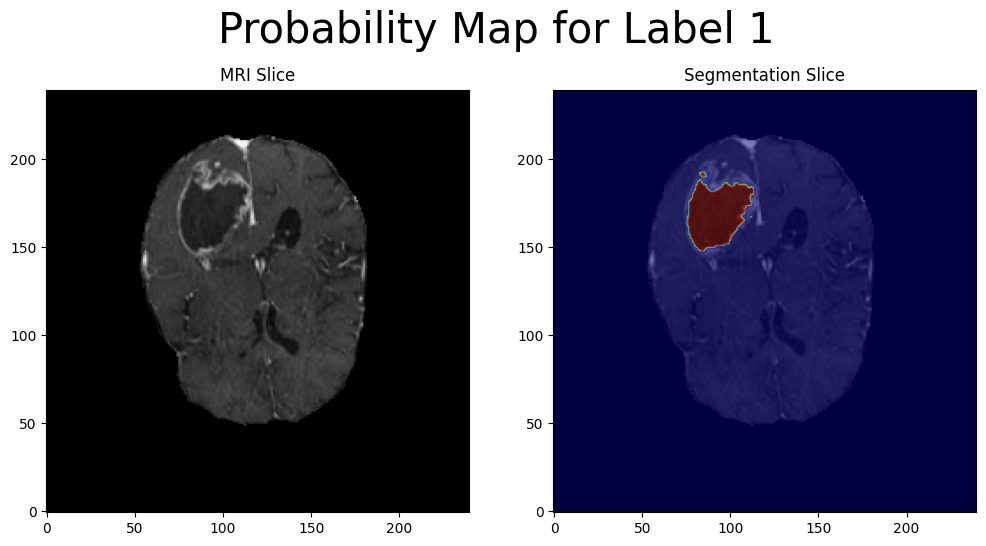

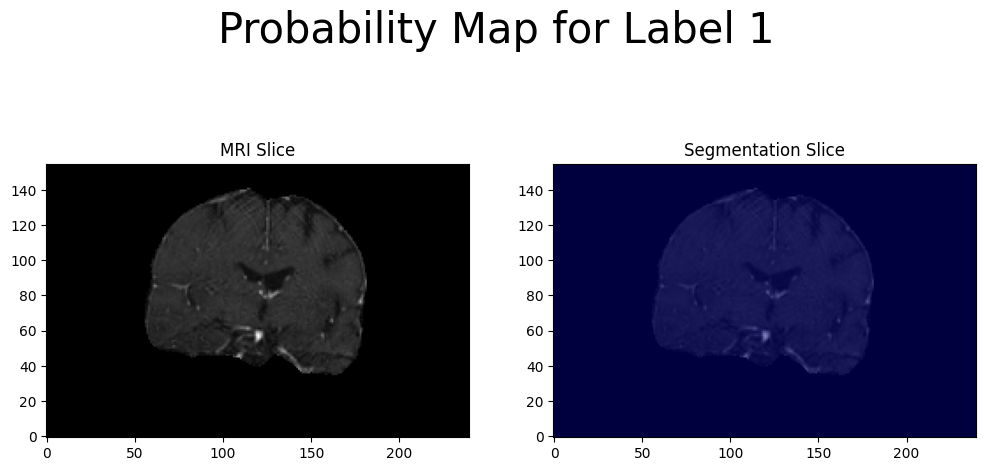

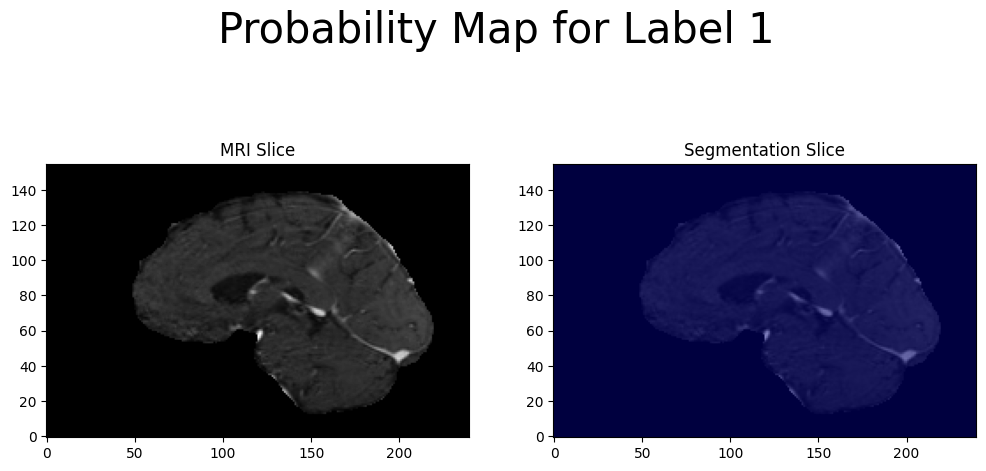

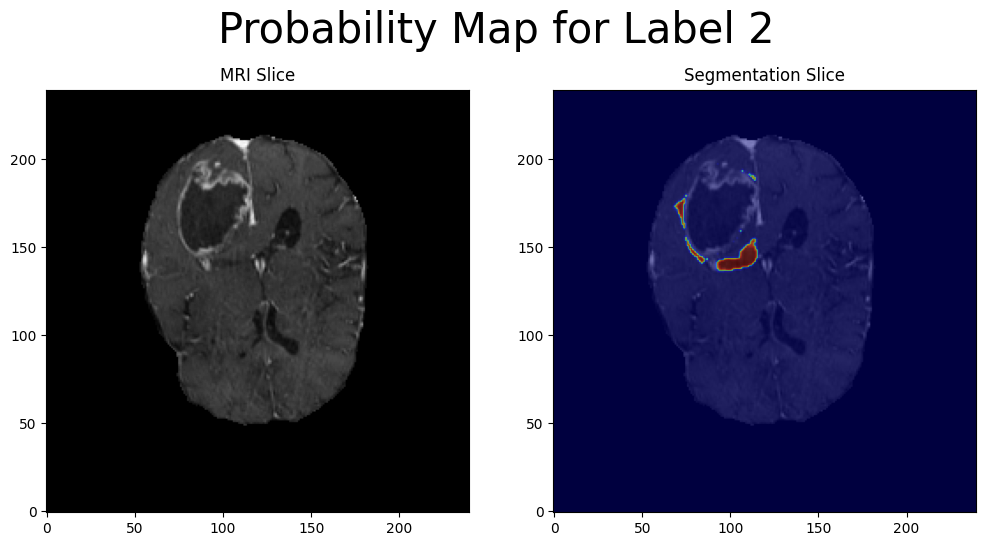

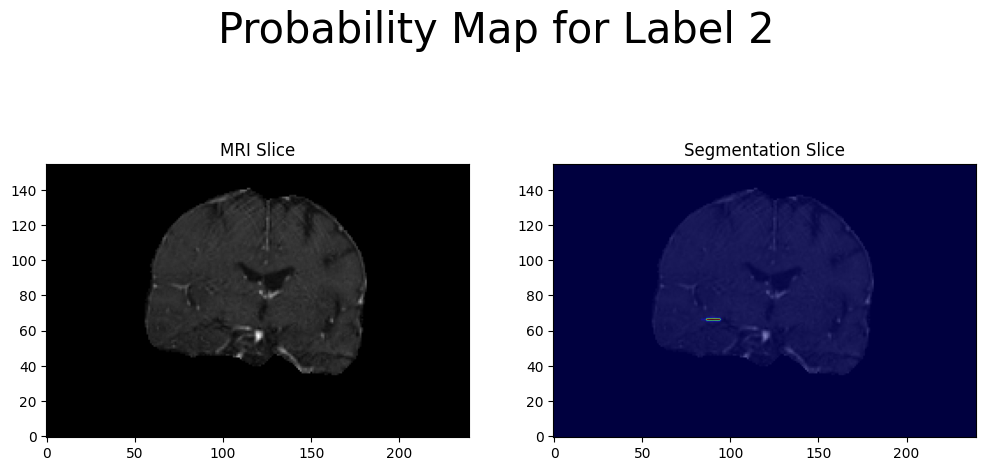

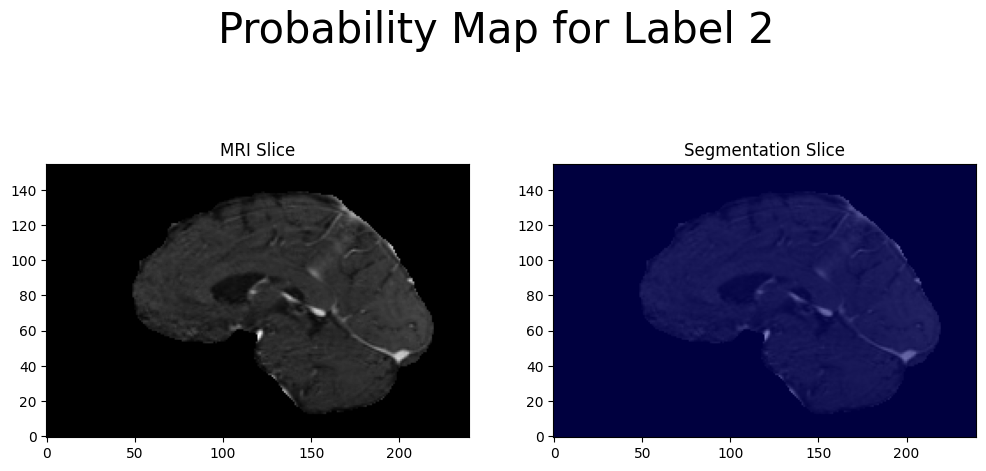

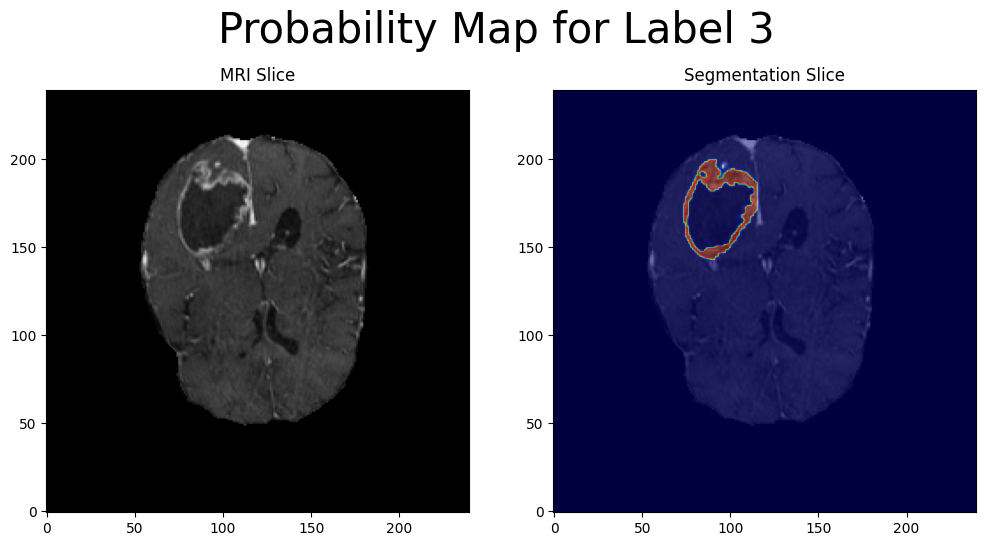

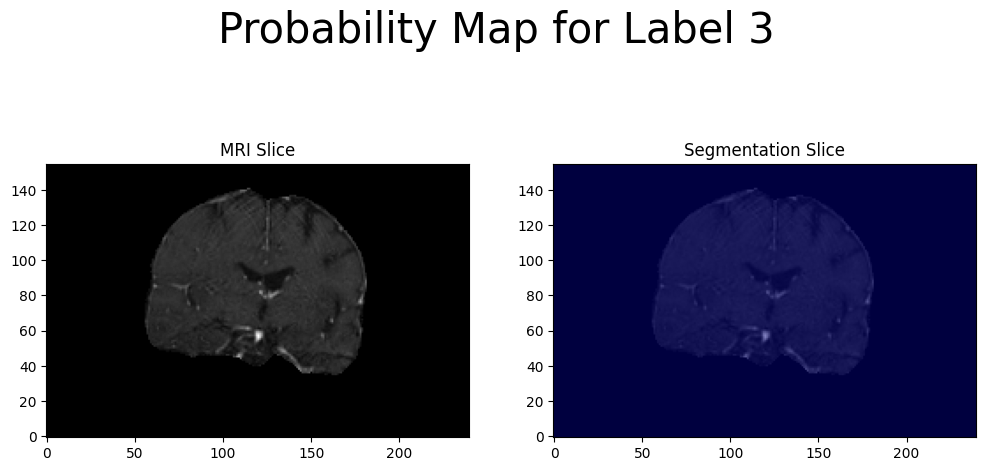

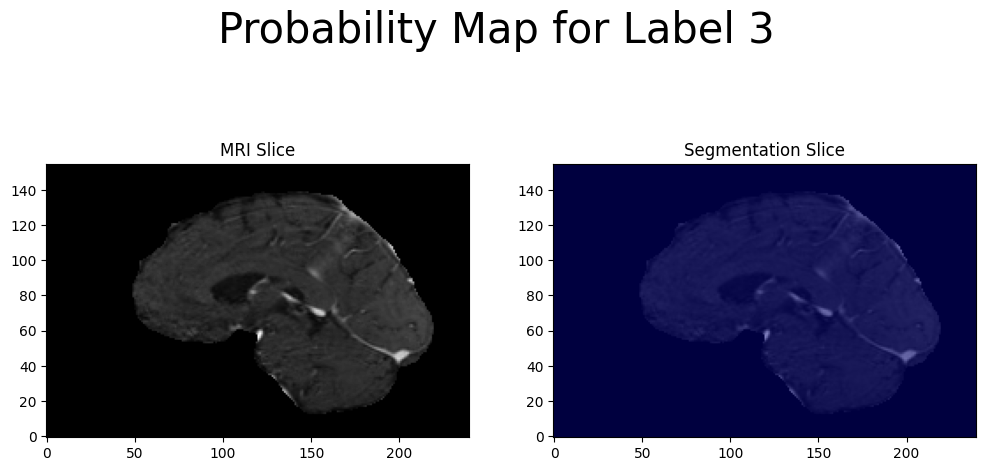

In [24]:
# Plot overlaid masks 

for i in range(filtered_oh_seg.shape[0]):
    channel = filtered_oh_seg[i]

    xy_seg_slice = get_central_slice(channel, axis = 2)
    xz_seg_slice = get_central_slice(channel, axis = 1)
    yz_seg_slice = get_central_slice(channel, axis = 0)

    plot_slices(xy_img_slice, xy_seg_slice, omit_background=False, plt_title='Probability Map for Label ' + str(i))
    plot_slices(xz_img_slice, xz_seg_slice, omit_background=False, plt_title='Probability Map for Label ' + str(i))
    plot_slices(yz_img_slice, yz_seg_slice, omit_background=False, plt_title='Probability Map for Label ' + str(i))

# Test Dilation

### Data Loading and converting to One Hot Format

In [4]:
#Loading actual data
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/'
train_list = create_bids_path_list_of_dicts(data_dir + '/train', suffix = 'fnio')

# 1. load image 
sample_idx = 3
img_path = train_list[sample_idx]['t1c']
seg_path = train_list[sample_idx]['seg']

img = fnio.load(str(img_path))
seg = fnio.load(str(seg_path))

# 2. transform to torch tensors (and add channel dim to img tensor)
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
seg_tensor = torch.tensor(seg, dtype=torch.long)

# 3. transform seg_tensor to one hot encoding and permute the dimensions
oh_seg = F.one_hot(seg_tensor, num_classes=4)
oh_seg = oh_seg.permute(3, 0, 1, 2)

# 4. convert GT to numpy array
oh_seg_np = oh_seg.numpy()

print(f"shape of oh_seg_np: {oh_seg_np.shape}")

shape of oh_seg_np: (4, 240, 240, 155)


### Plot original Masks

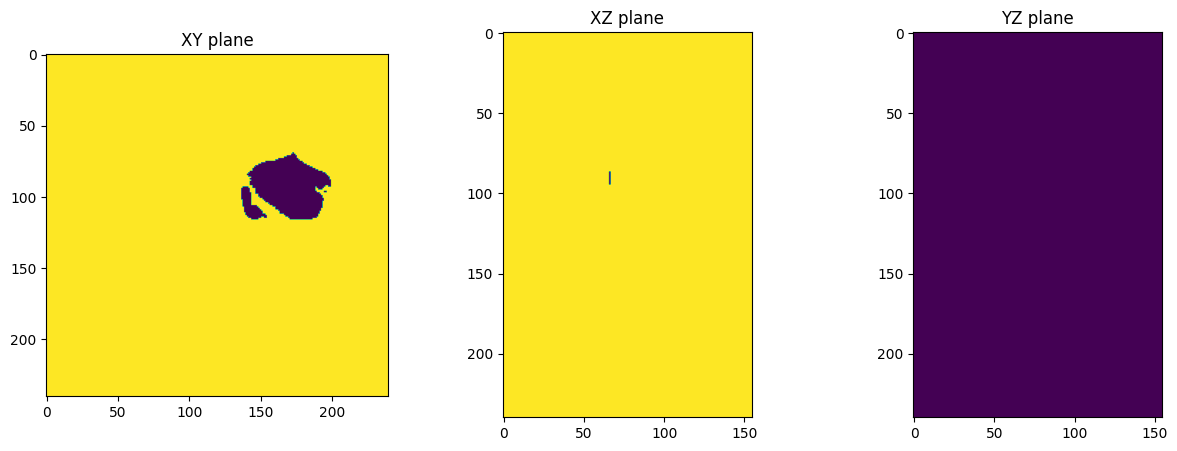

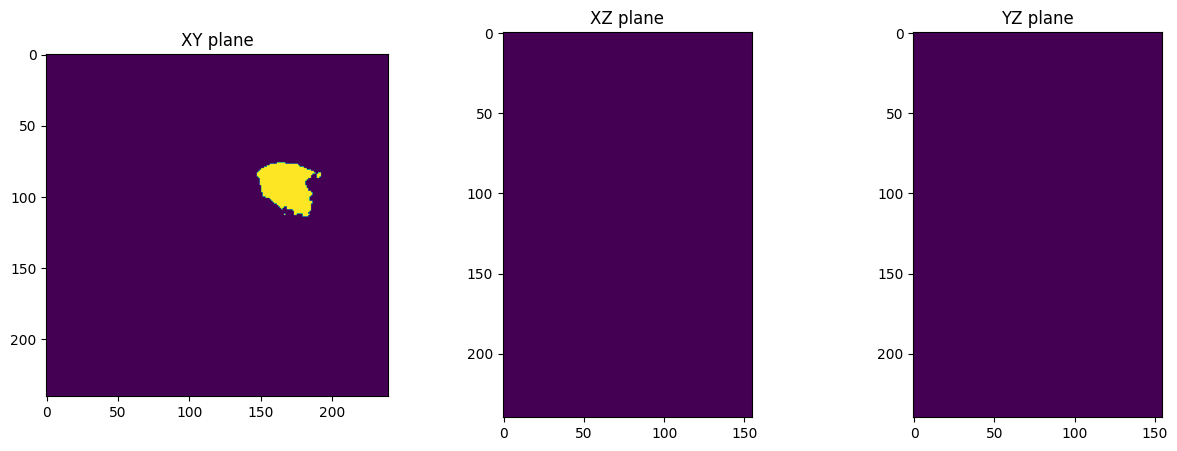

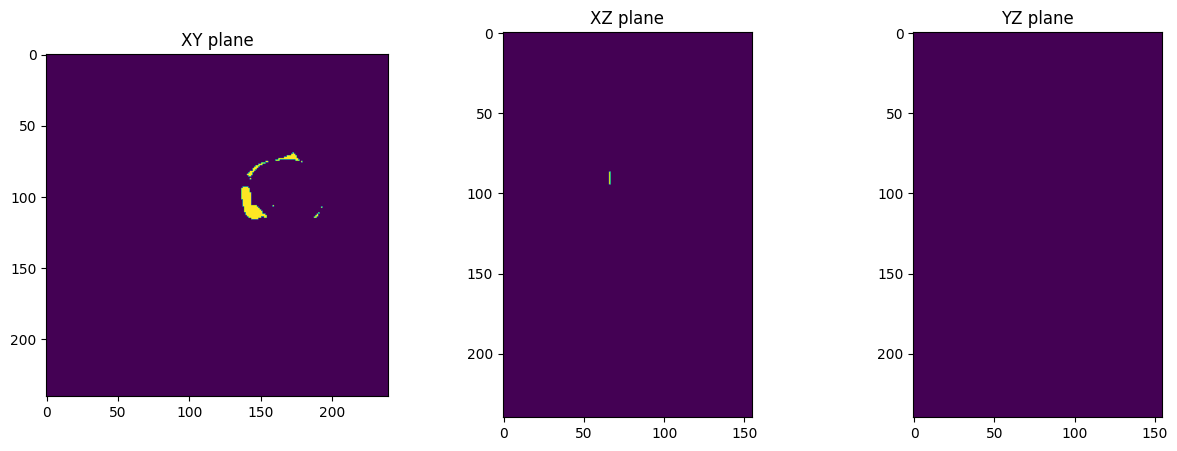

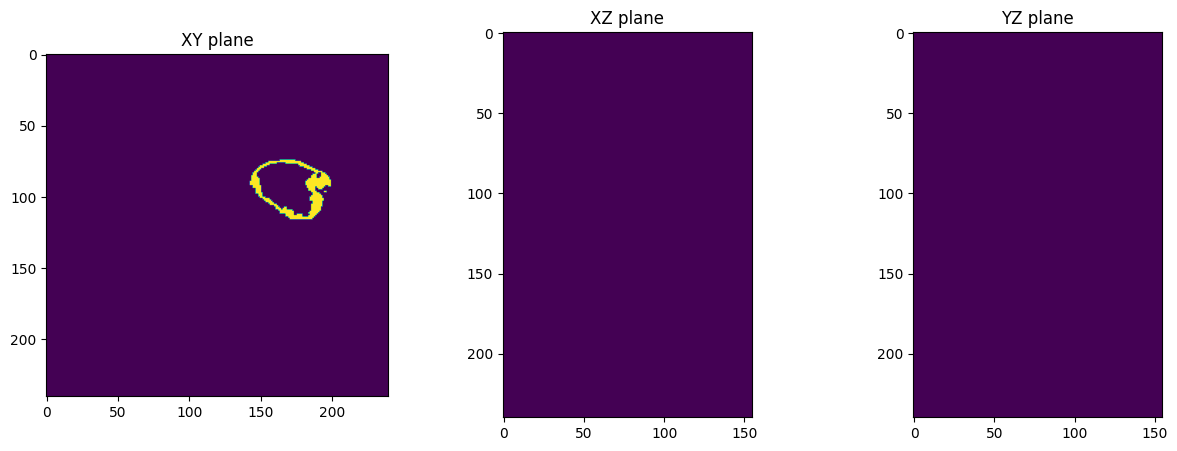

In [12]:
# Plot the original segmentation masks
for i in range(oh_seg_np.shape[0]):
    channel = oh_seg_np[i]

    xy_seg_slice = get_central_slice(channel, axis = 2)
    xz_seg_slice = get_central_slice(channel, axis = 1)
    yz_seg_slice = get_central_slice(channel, axis = 0)

    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_seg_slice)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_seg_slice)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_seg_slice)
    ax[2].set_title('YZ plane')

### Test naively using binary_dilation() from scipy.ndimage

In [15]:
# 5. Define the structuring element for 6-connectivity (cross shape)
structuring_element_6 = np.zeros((3, 3, 3), dtype=int)
structuring_element_6[1, 1, :] = 1
structuring_element_6[1, :, 1] = 1
structuring_element_6[:, 1, 1] = 1

# 6. Create empty array to store the dilated segmentation
dilated_oh_seg = np.zeros_like(oh_seg_np)

# 7. Apply the Dilation
for channel in range(oh_seg_np.shape[0]):
    dilated_oh_seg[channel] = binary_dilation(oh_seg_np[channel], structure=structuring_element_6)

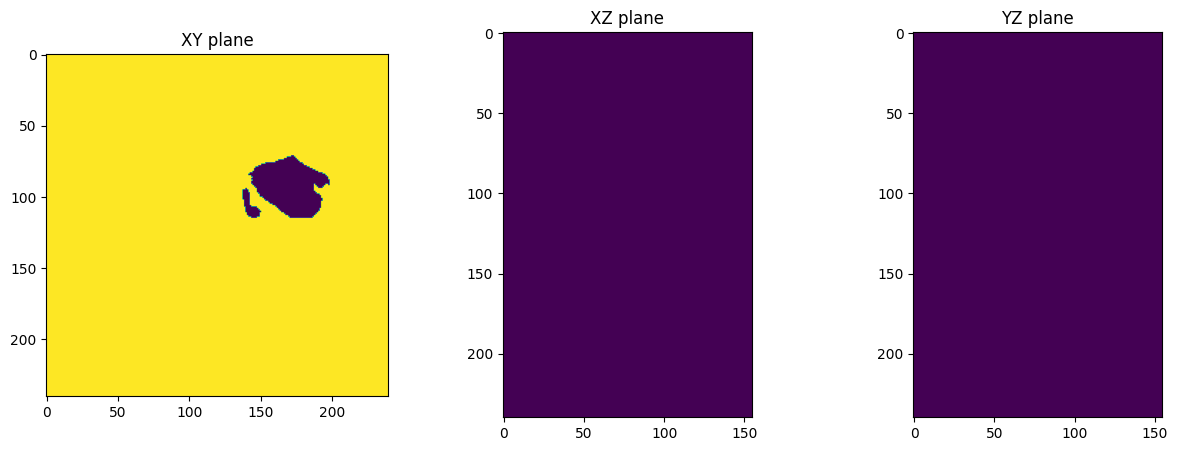

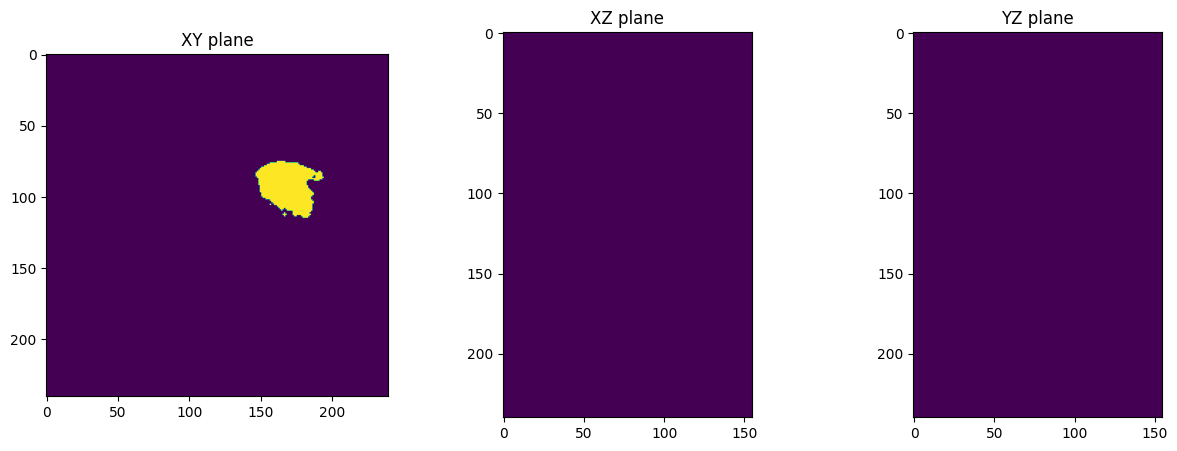

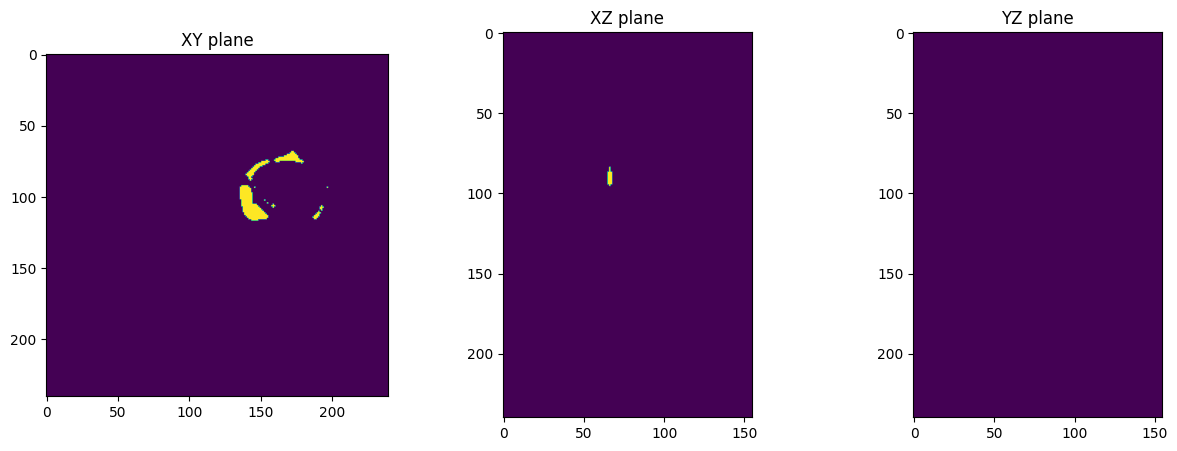

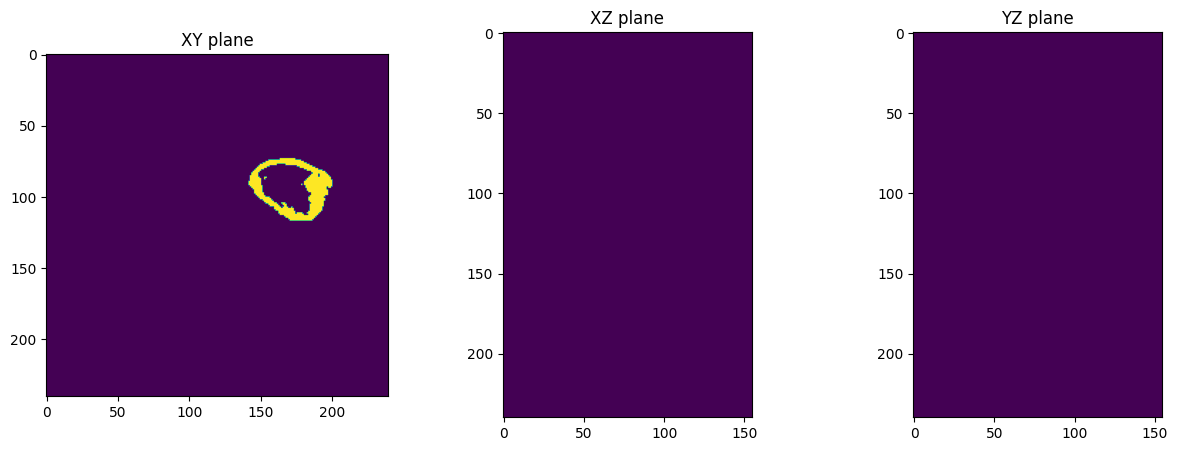

In [10]:
# Plot the dilated segmentation masks
for i in range(dilated_oh_seg.shape[0]):
    channel = dilated_oh_seg[i]

    xy_seg_slice = get_central_slice(channel, axis = 2)
    xz_seg_slice = get_central_slice(channel, axis = 1)
    yz_seg_slice = get_central_slice(channel, axis = 0)

    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_seg_slice)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_seg_slice)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_seg_slice)
    ax[2].set_title('YZ plane')

unique values in difference: [0 1]
unique values in difference: [0 1]
unique values in difference: [0 1]
unique values in difference: [0 1]


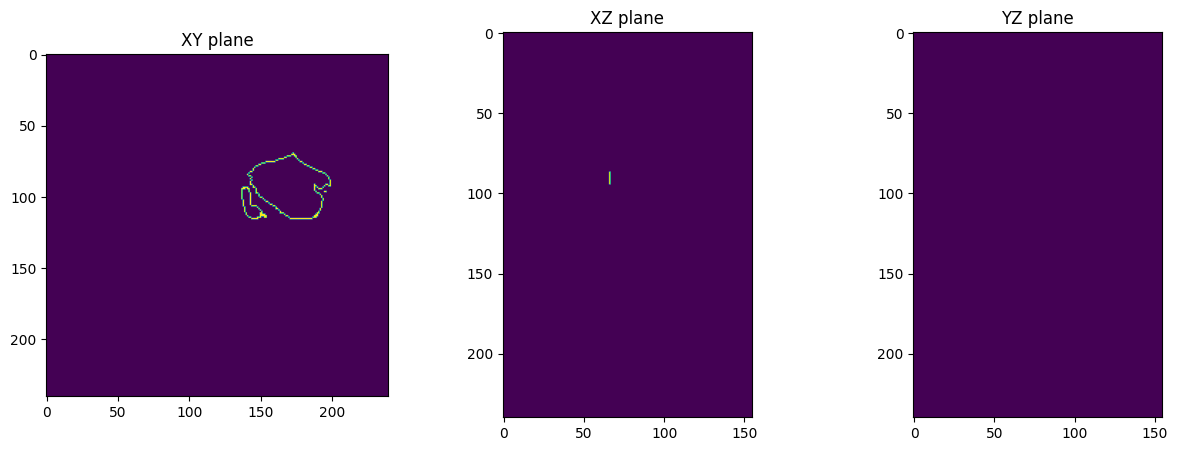

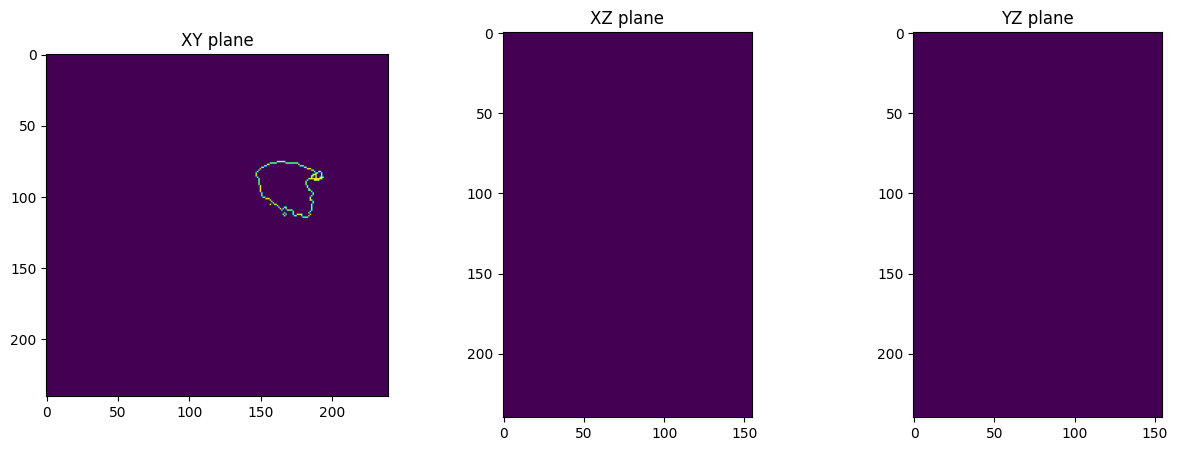

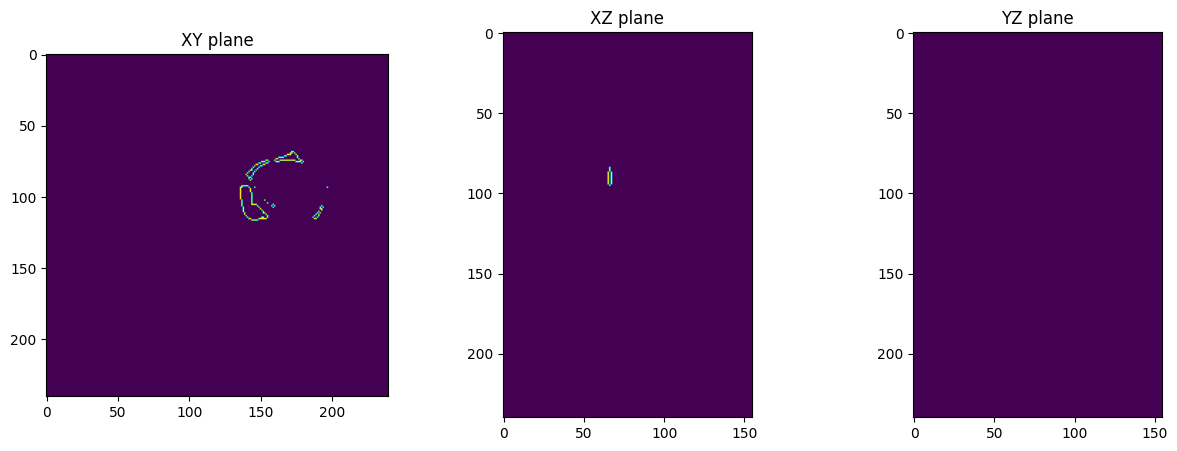

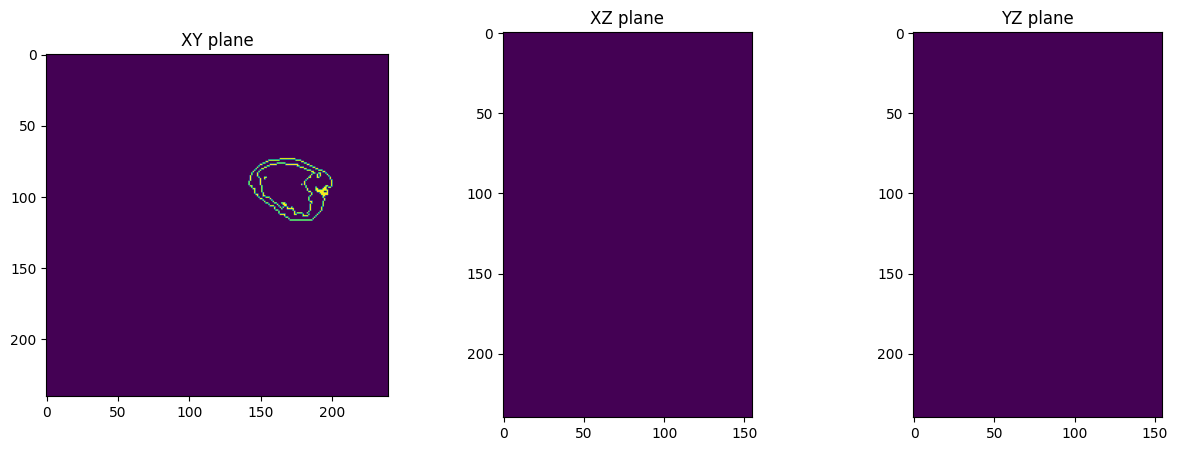

In [11]:
# Plot the difference between the original and the dilated segmentation masks
for i in range(dilated_oh_seg.shape[0]):
    channel = dilated_oh_seg[i]
    original_channel = oh_seg_np[i]

    difference = channel - original_channel

    print(f"unique values in difference: {np.unique(difference)}")

    xy_diff = get_central_slice(difference, axis = 2)
    xz_diff = get_central_slice(difference, axis = 1)
    yz_diff = get_central_slice(difference, axis = 0)

    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_diff)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_diff)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_diff)
    ax[2].set_title('YZ plane')

### Test using methods from TPTBox

#### Dilate with Pixel Connectivity 1

In [22]:
# 5. Create empty array to store the dilated segmentation
dilated_oh_seg_np = np.zeros_like(oh_seg_np)

# 6. Apply the Dilation
pixel_connectivity = 1
for channel in range(oh_seg_np.shape[0]):
    dilated_oh_seg_np[channel] = np_utils.np_dilate_msk(oh_seg_np[channel], mm=1, connectivity=pixel_connectivity)

##### Plot Dilated Masks for connectivity 1

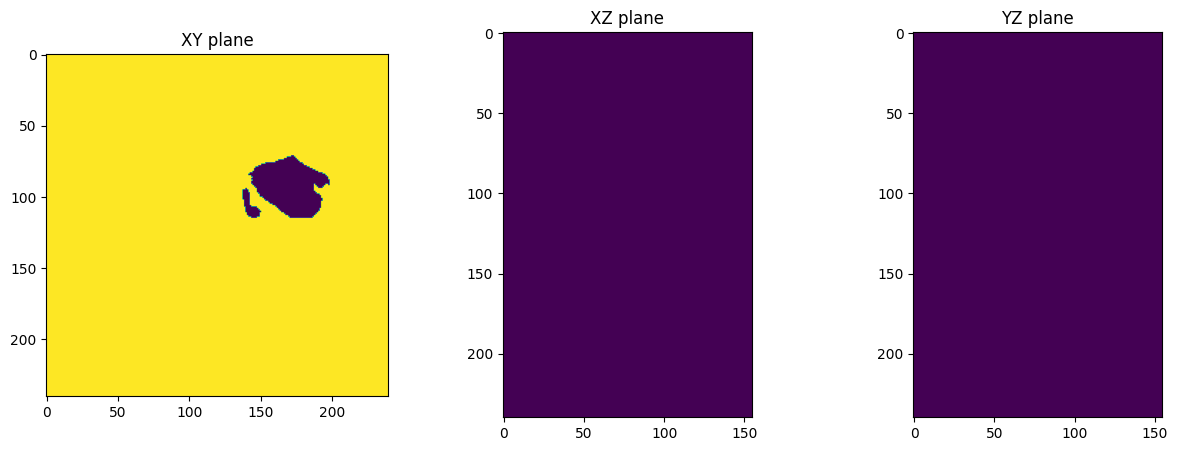

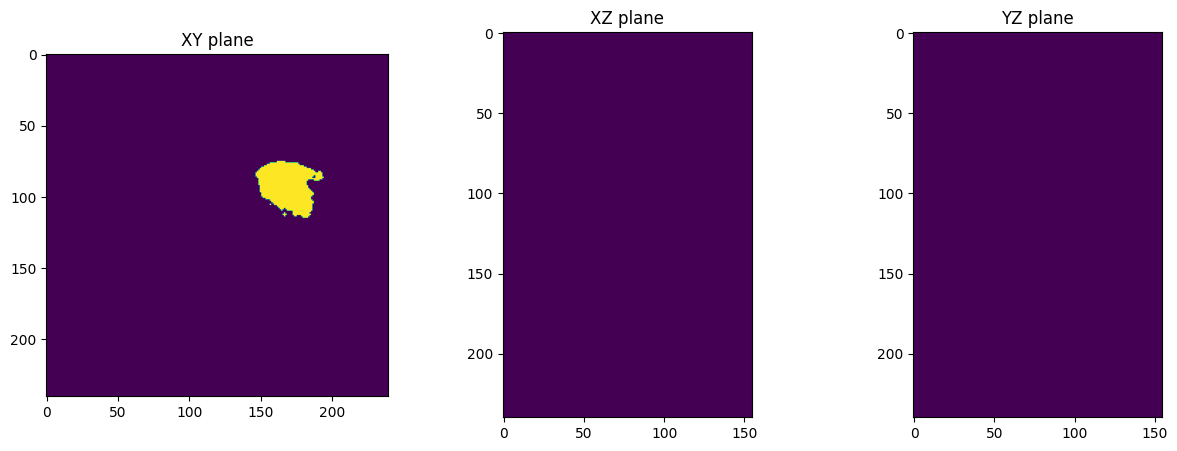

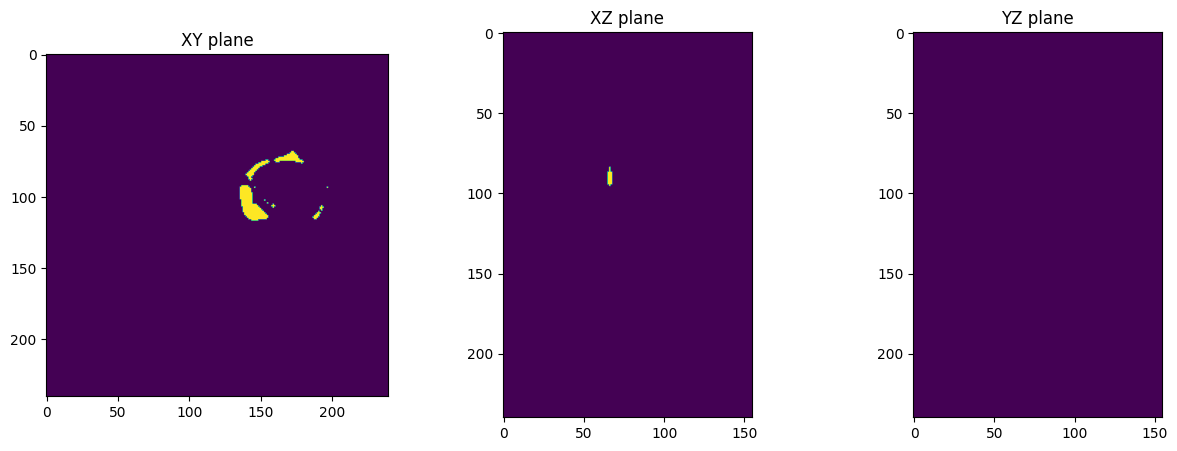

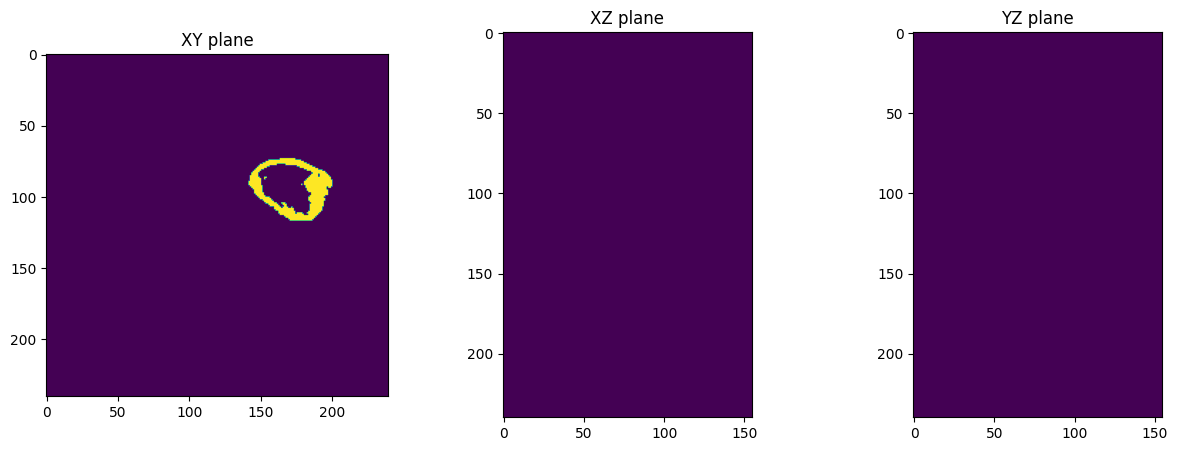

In [23]:
# Plot the dilated segmentation masks
for i in range(dilated_oh_seg_np.shape[0]):
    channel = dilated_oh_seg_np[i]

    xy_seg_slice = get_central_slice(channel, axis = 2)
    xz_seg_slice = get_central_slice(channel, axis = 1)
    yz_seg_slice = get_central_slice(channel, axis = 0)

    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_seg_slice)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_seg_slice)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_seg_slice)
    ax[2].set_title('YZ plane')

##### Plot Difference between dilated and original mask for connectivity 1

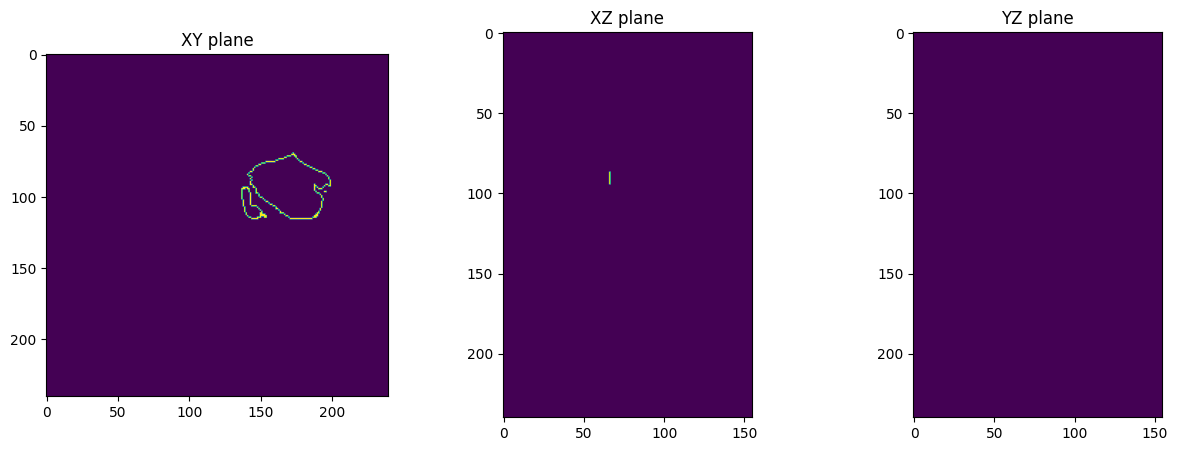

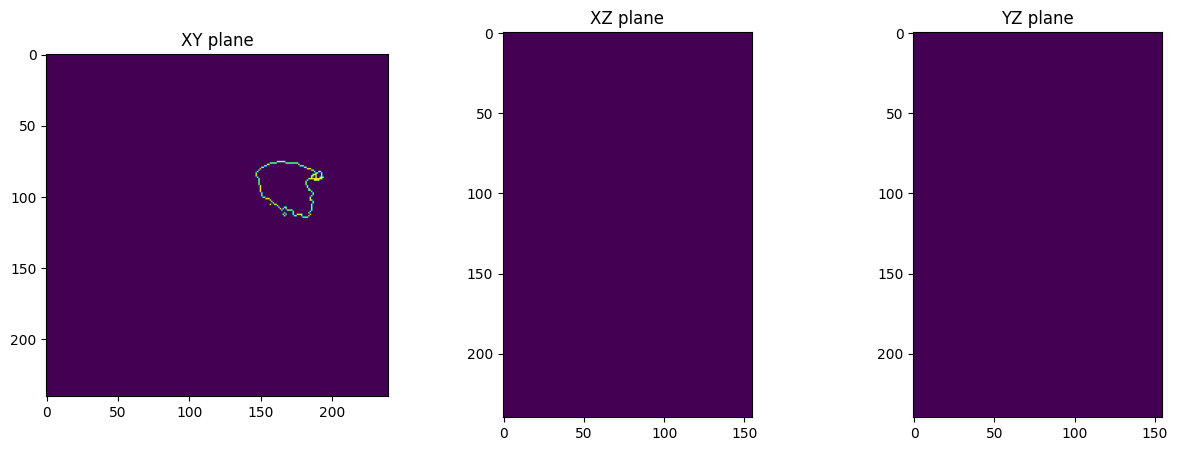

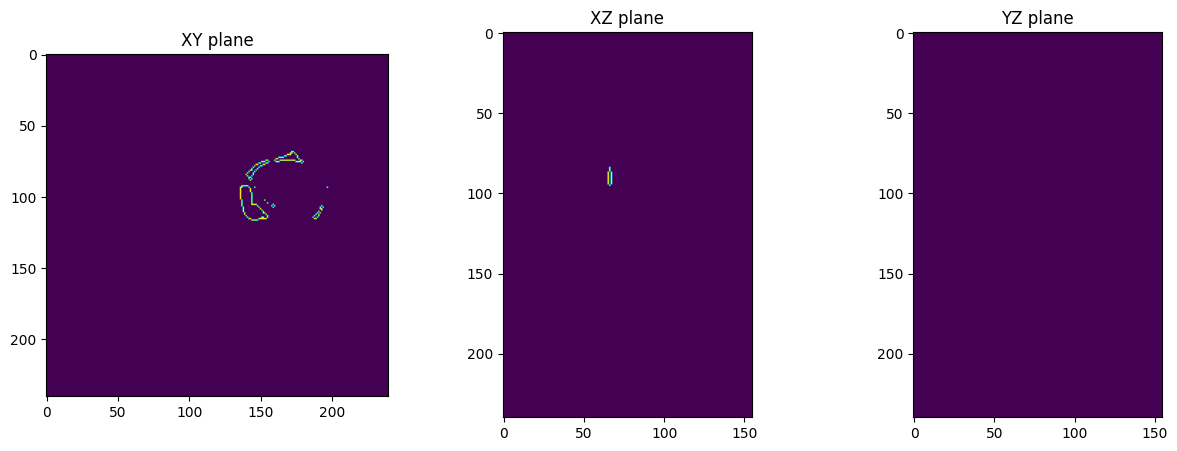

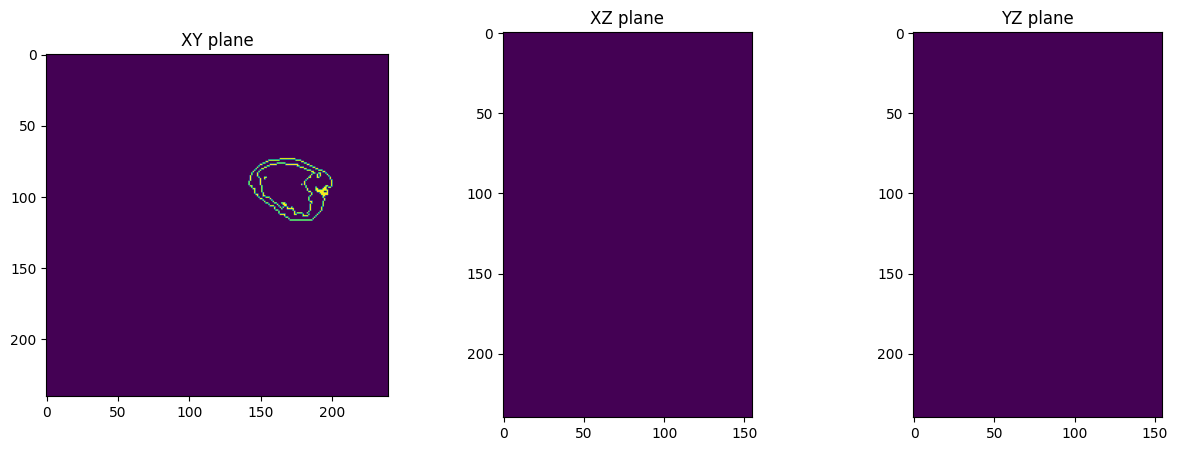

In [24]:
# Plot the difference between the original and the filtered segmentation masks
for i in range(dilated_oh_seg_np.shape[0]):
    channel = dilated_oh_seg_np[i]
    original_channel = oh_seg_np[i]

    difference = channel - original_channel

    xy_diff = get_central_slice(difference, axis = 2)
    xz_diff = get_central_slice(difference, axis = 1)
    yz_diff = get_central_slice(difference, axis = 0)

    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_diff)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_diff)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_diff)
    ax[2].set_title('YZ plane')

#### Dilate with Pixel Connectivity 3

In [27]:
# 5. Create empty array to store the dilated segmentation
dilated_oh_seg_np = np.zeros_like(oh_seg_np)

# 6. Apply the Dilation
pixel_connectivity = 3
for channel in range(oh_seg_np.shape[0]):
    dilated_oh_seg_np[channel] = np_utils.np_dilate_msk(oh_seg_np[channel], mm=1, connectivity=pixel_connectivity)

##### Plot Dilated Masks for connectivity 3

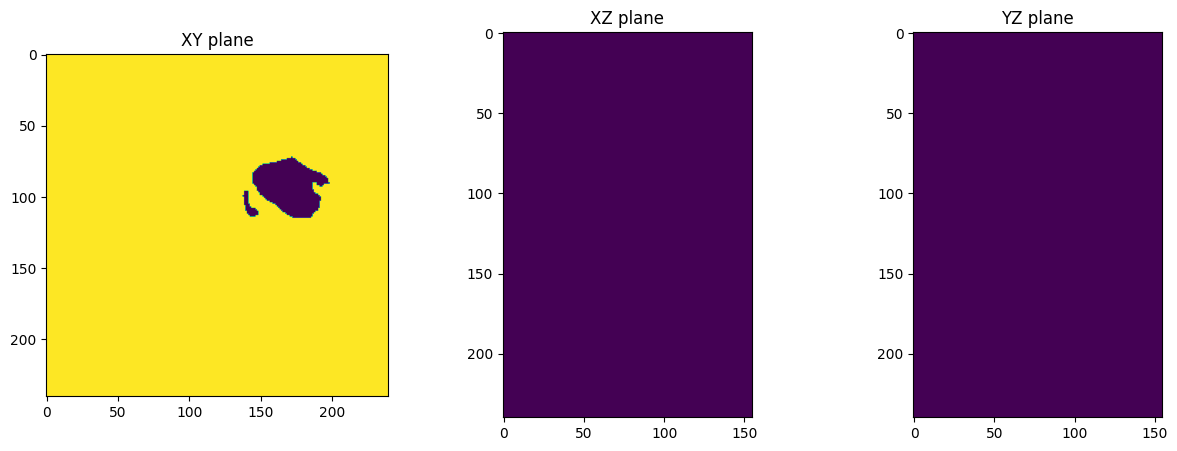

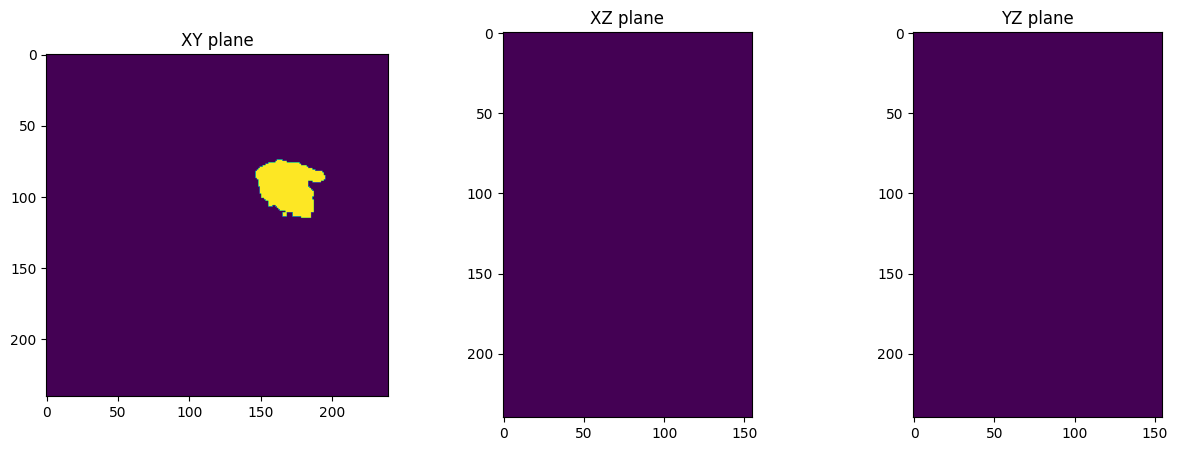

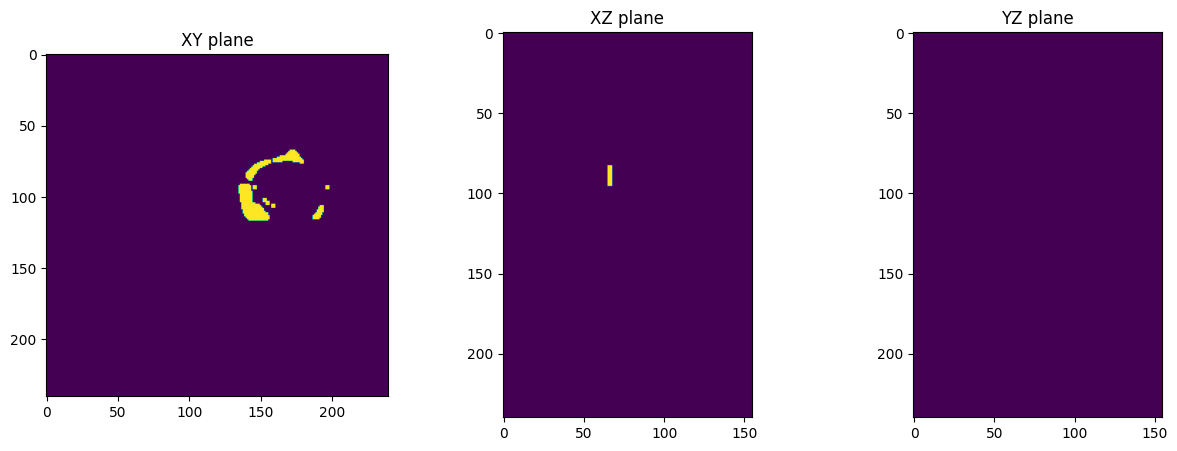

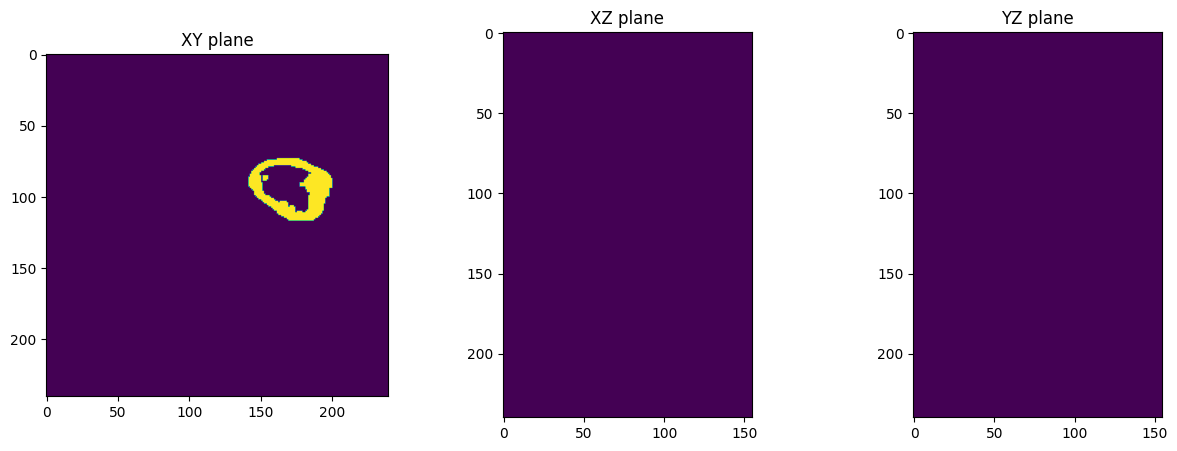

In [28]:
# Plot the dilated segmentation masks
for i in range(dilated_oh_seg_np.shape[0]):
    channel = dilated_oh_seg_np[i]

    xy_seg_slice = get_central_slice(channel, axis = 2)
    xz_seg_slice = get_central_slice(channel, axis = 1)
    yz_seg_slice = get_central_slice(channel, axis = 0)

    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_seg_slice)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_seg_slice)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_seg_slice)
    ax[2].set_title('YZ plane')

##### Plot Difference between dilated and original mask for connectivity 3

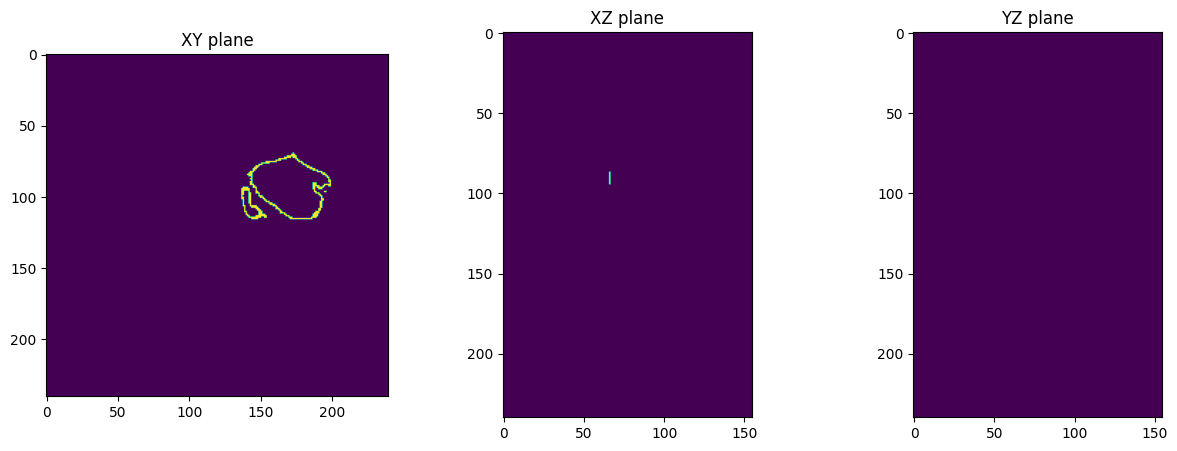

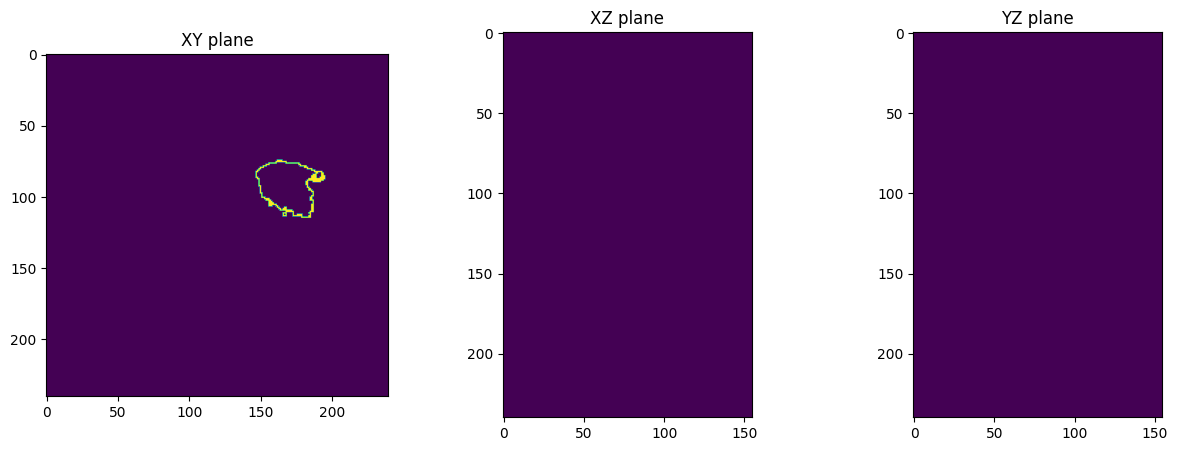

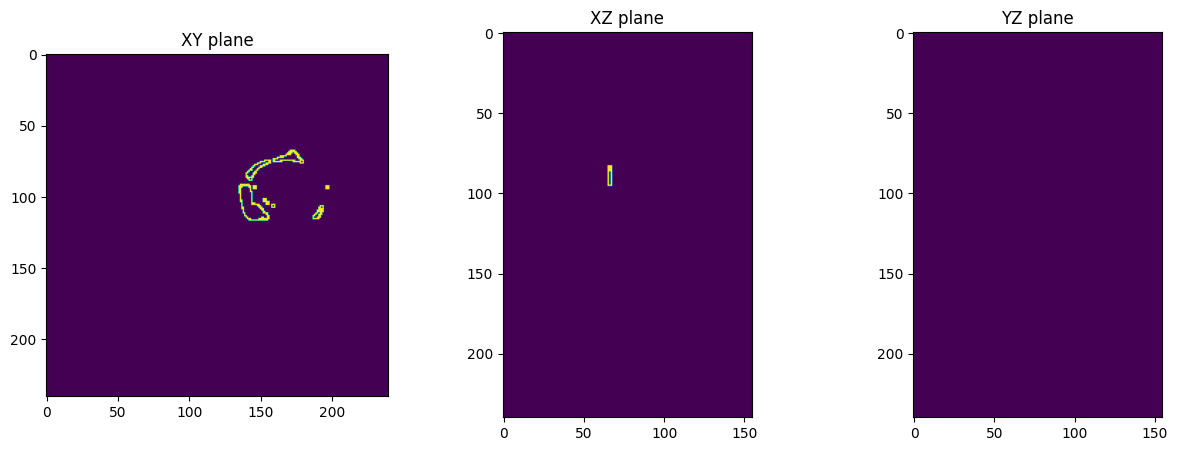

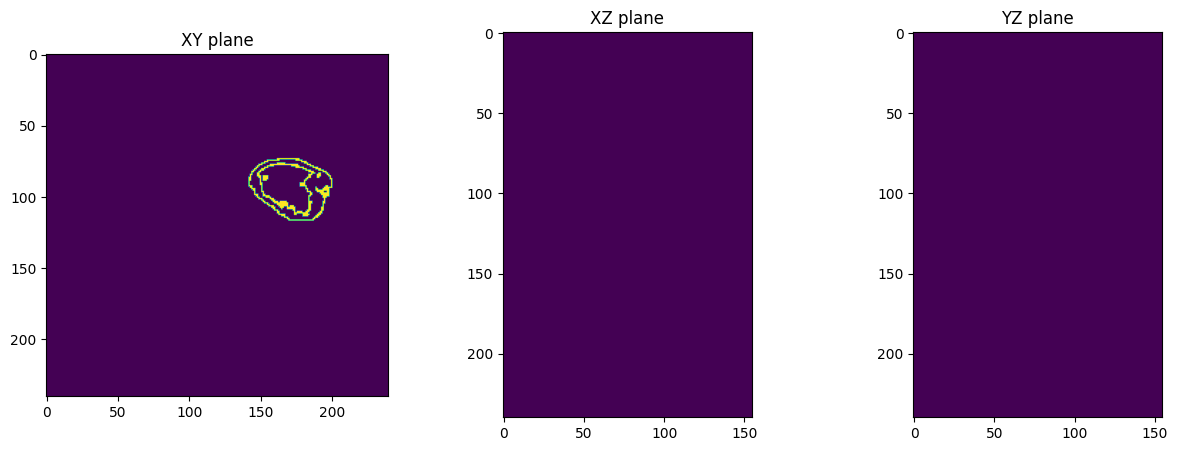

In [29]:
# Plot the difference between the original and the filtered segmentation masks
for i in range(dilated_oh_seg_np.shape[0]):
    channel = dilated_oh_seg_np[i]
    original_channel = oh_seg_np[i]

    difference = channel - original_channel

    xy_diff = get_central_slice(difference, axis = 2)
    xz_diff = get_central_slice(difference, axis = 1)
    yz_diff = get_central_slice(difference, axis = 0)

    #plot all three next to each other
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].imshow(xy_diff)
    ax[0].set_title('XY plane')
    ax[1].imshow(xz_diff)
    ax[1].set_title('XZ plane')
    ax[2].imshow(yz_diff)
    ax[2].set_title('YZ plane')

# Test Manual Softening by setting boundary voxels to 0.5

## Data Loading and Processing

### Loading and one-hot encoding

In [44]:
#Loading actual data
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/'
train_list = create_bids_path_list_of_dicts(data_dir + '/train', suffix = 'fnio')

# 1. load image 
sample_idx = 3
img_path = train_list[sample_idx]['t1c']
seg_path = train_list[sample_idx]['seg']

img = fnio.load(str(img_path))
seg = fnio.load(str(seg_path))

# 2. transform to torch tensors (and add channel dim to img tensor)
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
seg_tensor = torch.tensor(seg, dtype=torch.long)

# 3. transform seg_tensor to one hot encoding and permute the dimensions
oh_seg = F.one_hot(seg_tensor, num_classes=4)
oh_seg = oh_seg.permute(3, 0, 1, 2)

# 4. convert GT to numpy array
oh_seg_np = oh_seg.numpy()

print(f"shape of oh_seg_np: {oh_seg_np.shape}")

shape of oh_seg_np: (4, 240, 240, 155)


### Plotting og masks

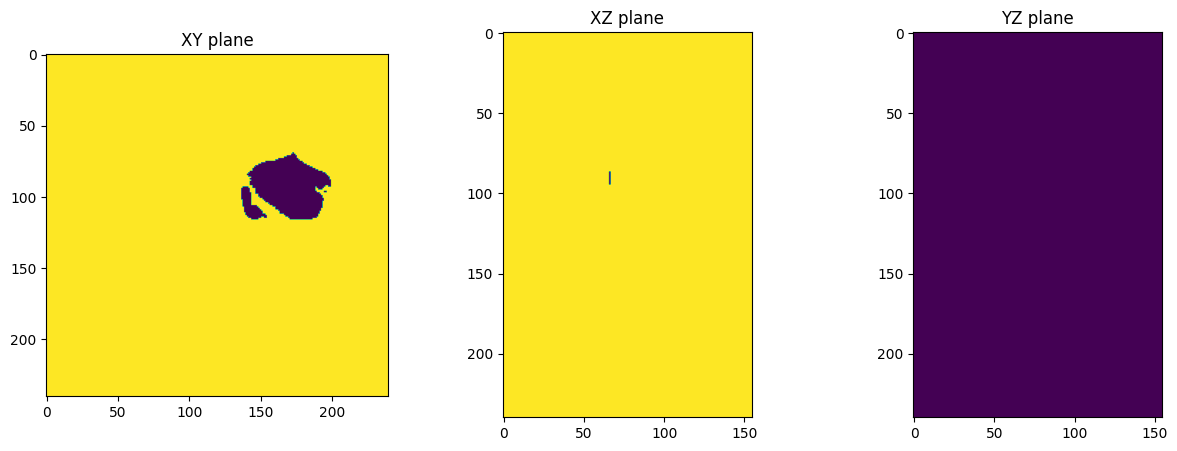

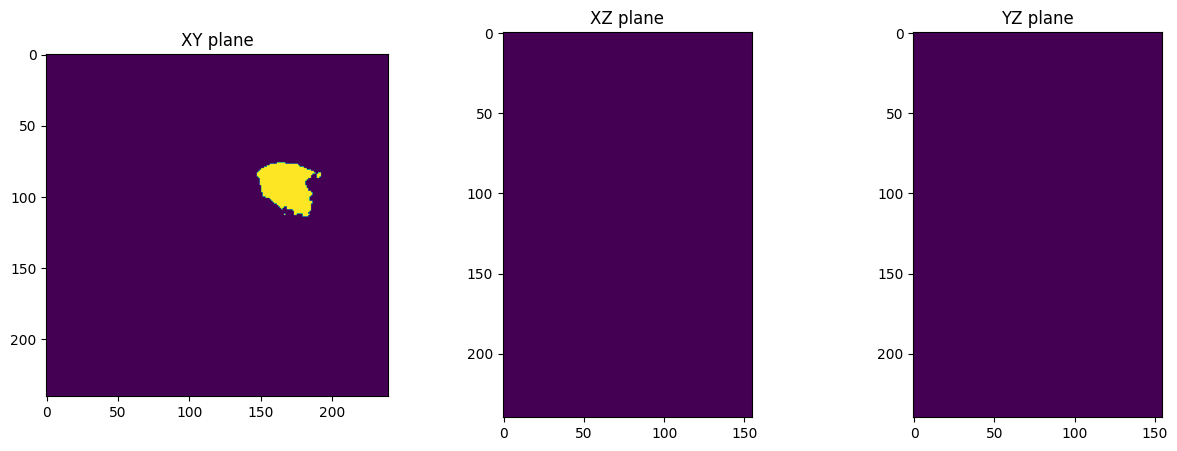

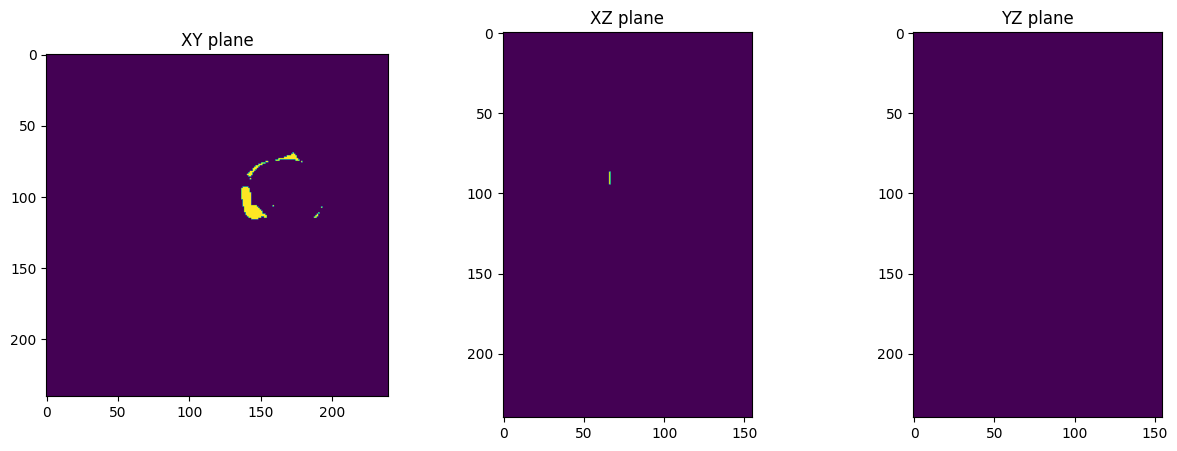

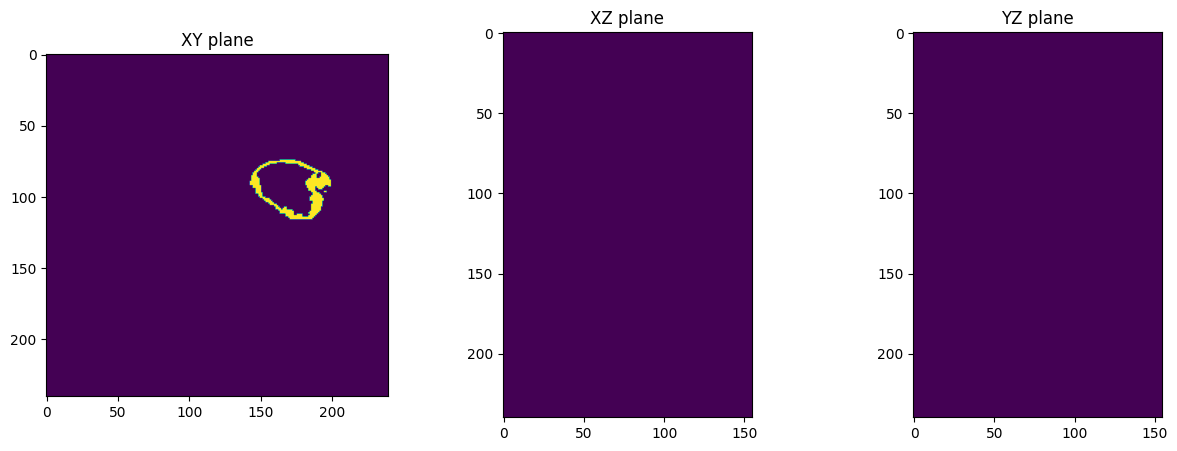

In [45]:
plot_all_slices(oh_seg_np)

## Determinining boundary voxels

#### Pixel Connectivity 1

##### Determining Border Voxels

In [38]:
# 5. Create empty array to store the eroded segmentation
eroded_oh_seg_np = np.zeros_like(oh_seg_np)

# 6. Apply the Dilation
pixel_connectivity = 1
for channel in range(oh_seg_np.shape[0]):
    eroded_oh_seg_np[channel] = np_utils.np_erode_msk(oh_seg_np[channel], mm=1, connectivity=pixel_connectivity)

# 7. Get the boundary by substracting the eroded mask from the og
boundary_oh_seg_np = oh_seg_np - eroded_oh_seg_np

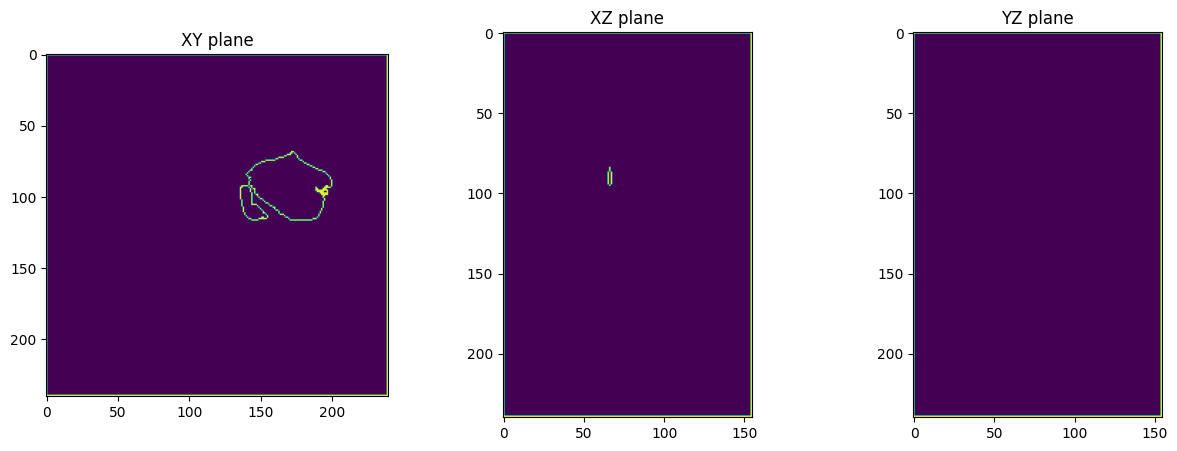

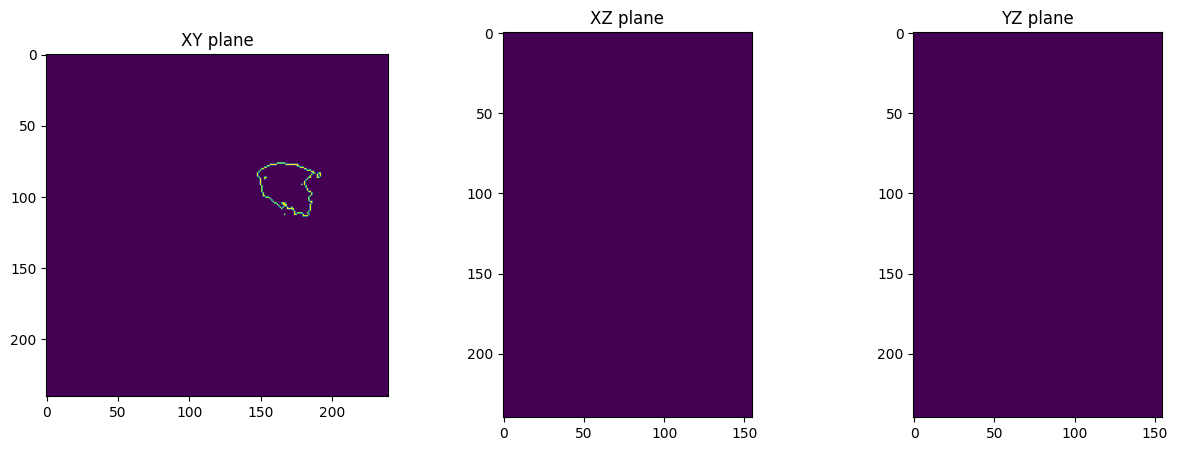

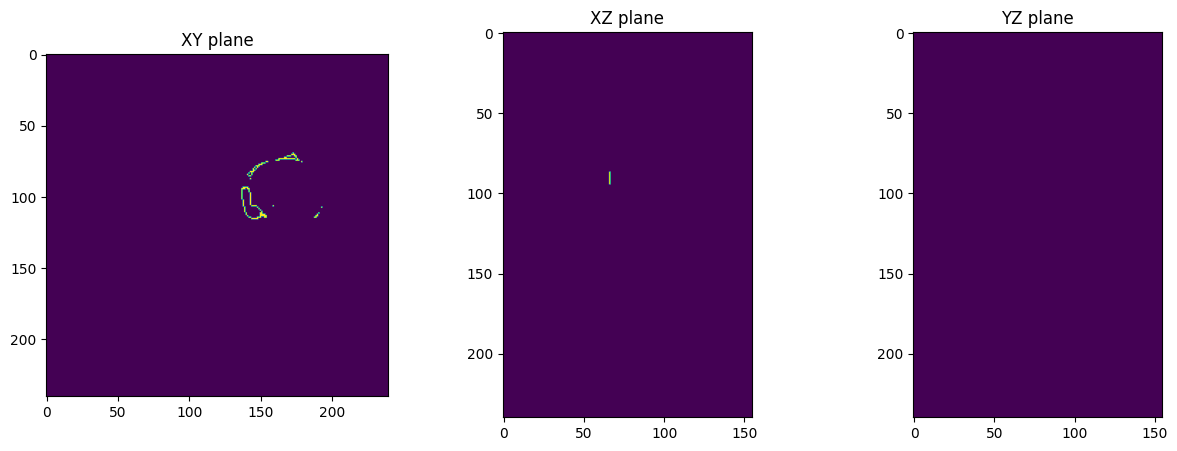

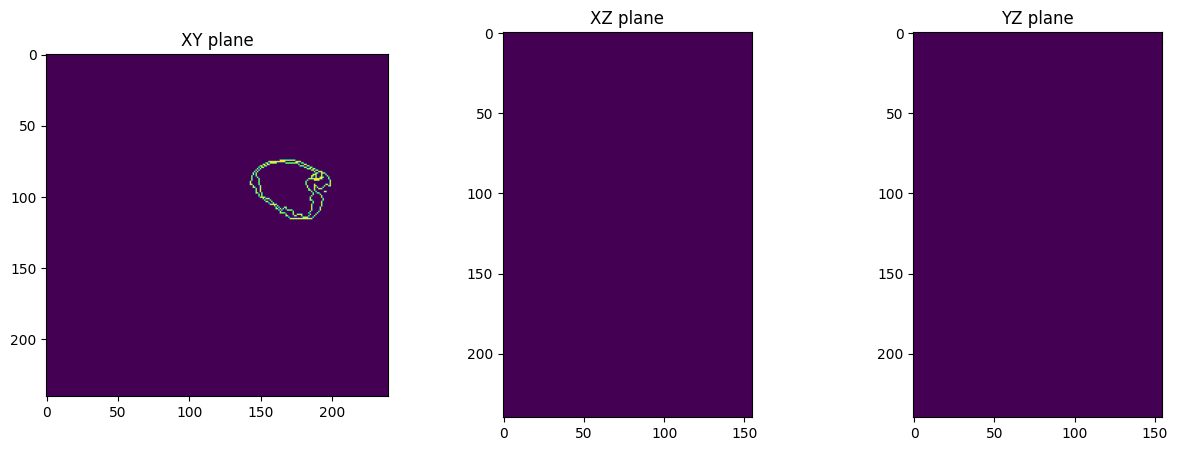

In [39]:
plot_all_slices(boundary_oh_seg_np)

##### Softening Border and creating new mask

In [40]:
soft_mask = eroded_oh_seg_np + boundary_oh_seg_np*0.5

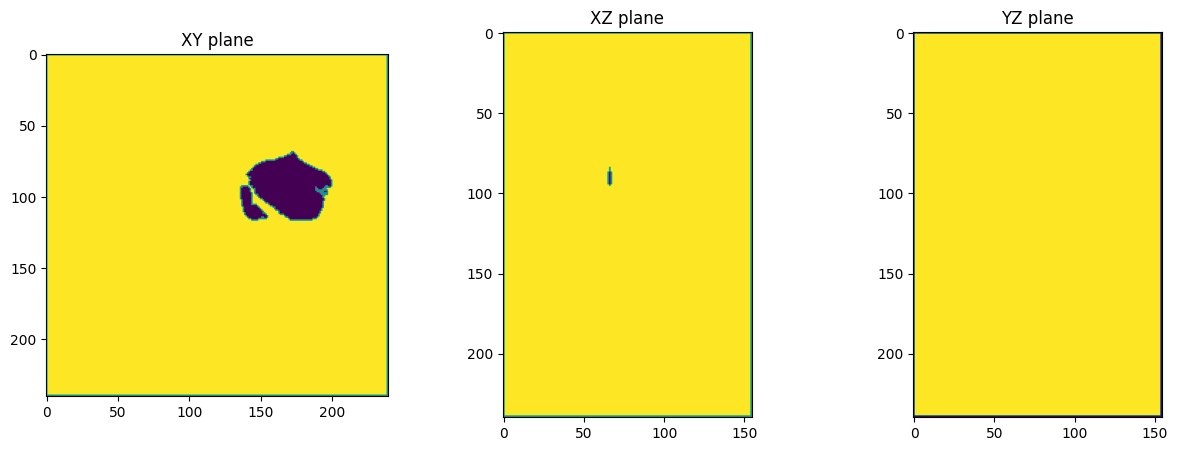

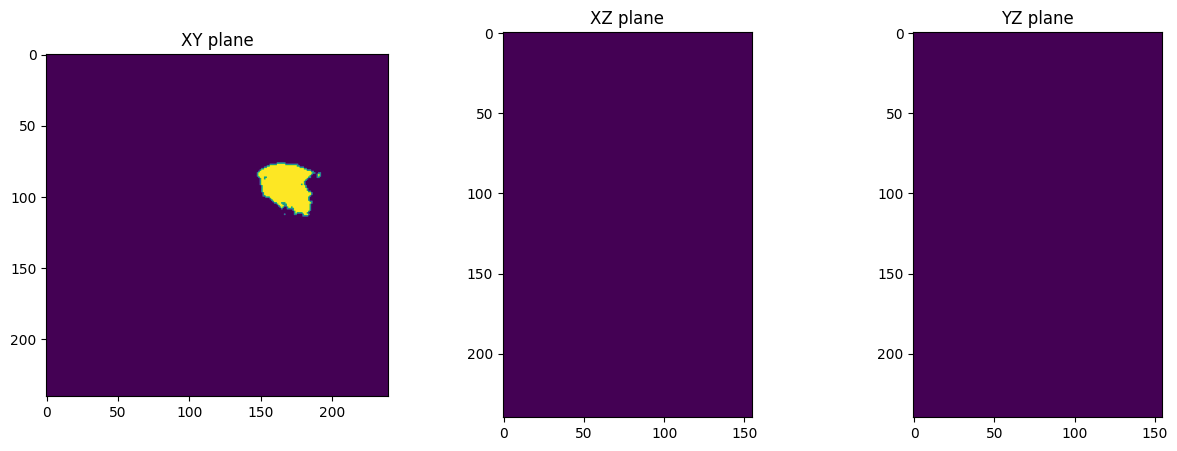

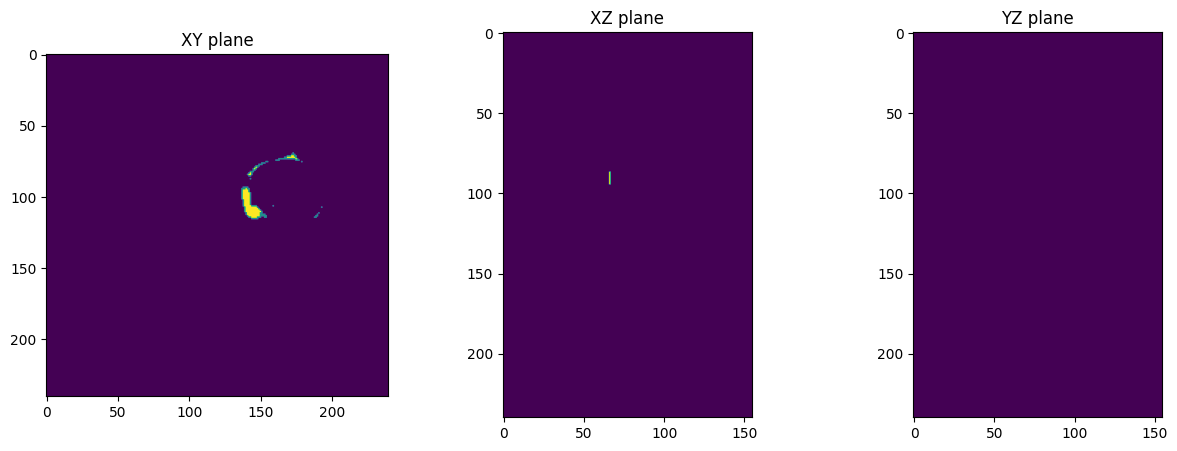

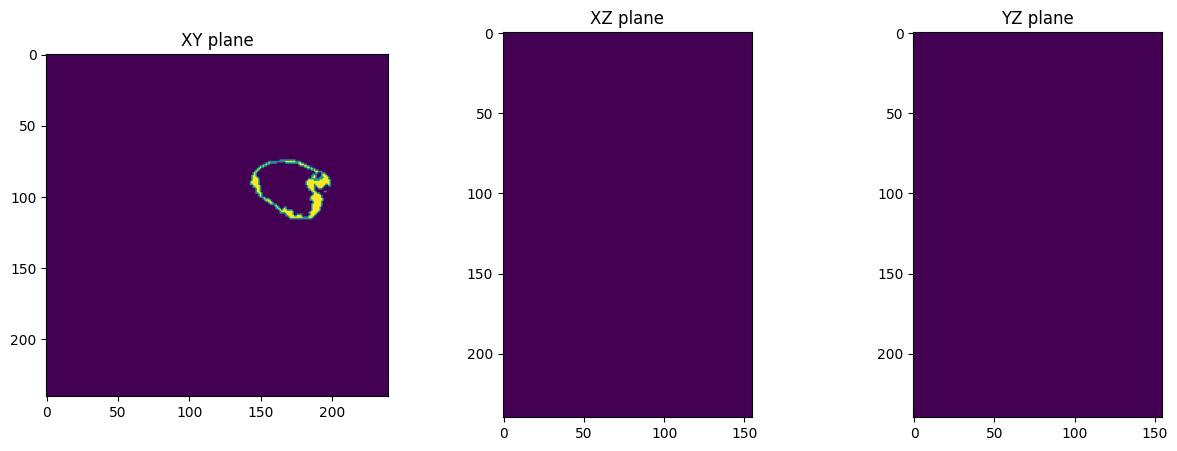

In [41]:
plot_all_slices(soft_mask)

#### Pixel Connectivity 3

##### Determining Border Voxels

In [46]:
# 5. Create empty array to store the eroded segmentation
eroded_oh_seg_np = np.zeros_like(oh_seg_np)

# 6. Apply the Dilation
pixel_connectivity = 3
for channel in range(oh_seg_np.shape[0]):
    eroded_oh_seg_np[channel] = np_utils.np_erode_msk(oh_seg_np[channel], mm=1, connectivity=pixel_connectivity)

# 7. Get the boundary by substracting the eroded mask from the og
boundary_oh_seg_np = oh_seg_np - eroded_oh_seg_np

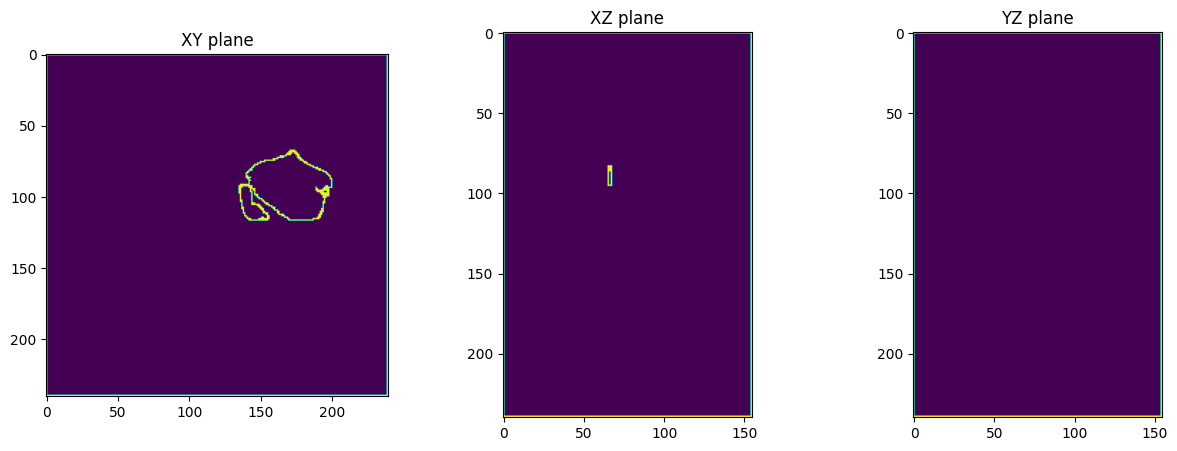

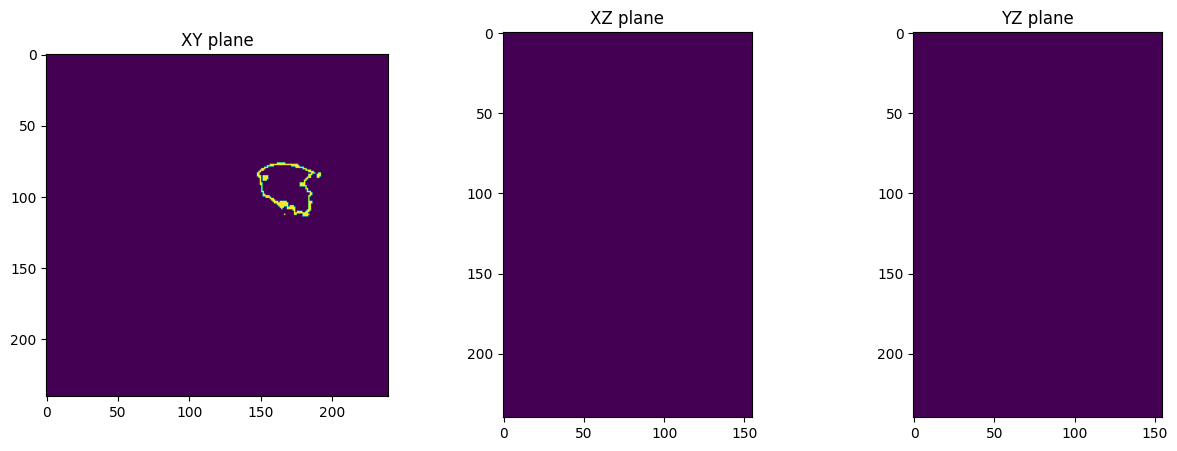

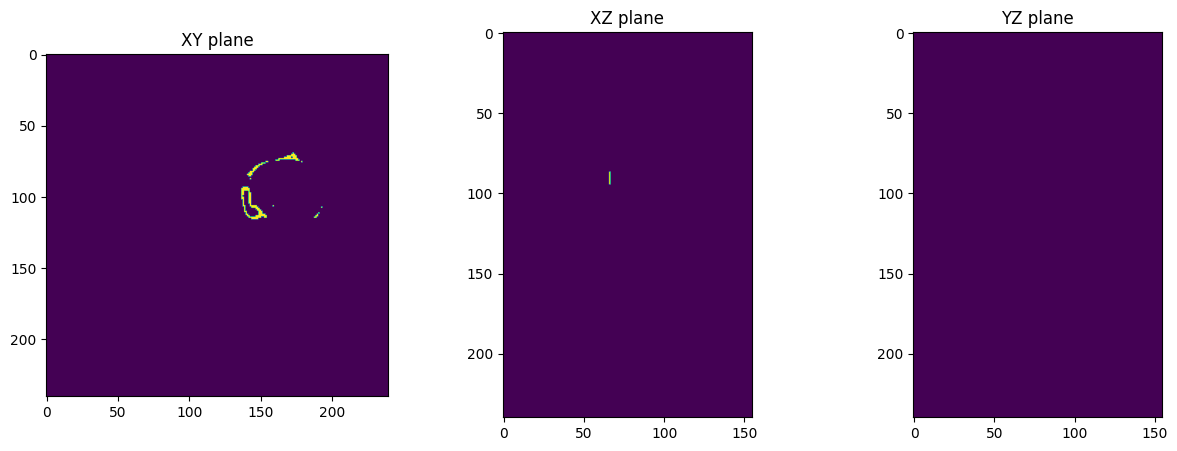

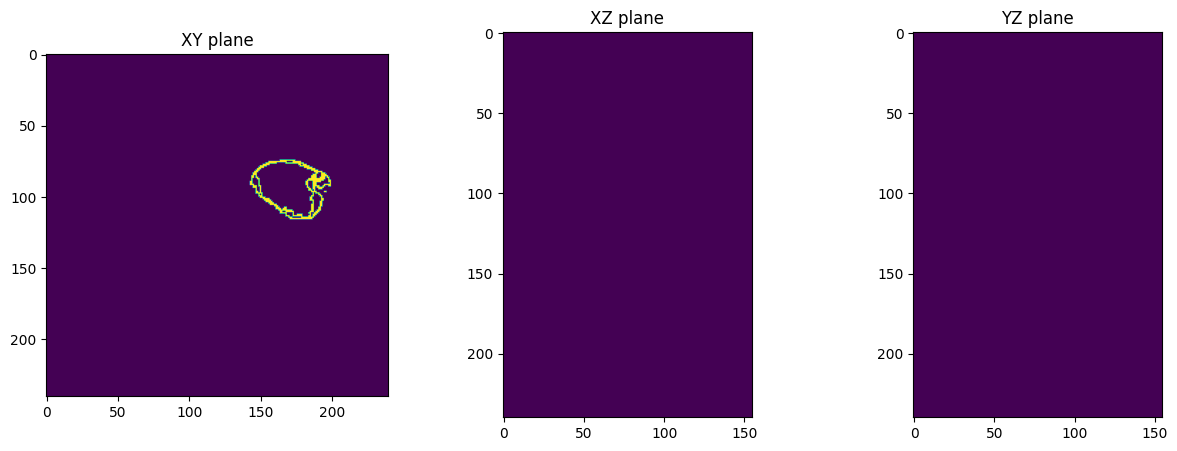

In [47]:
plot_all_slices(boundary_oh_seg_np)

##### Creating soft mask

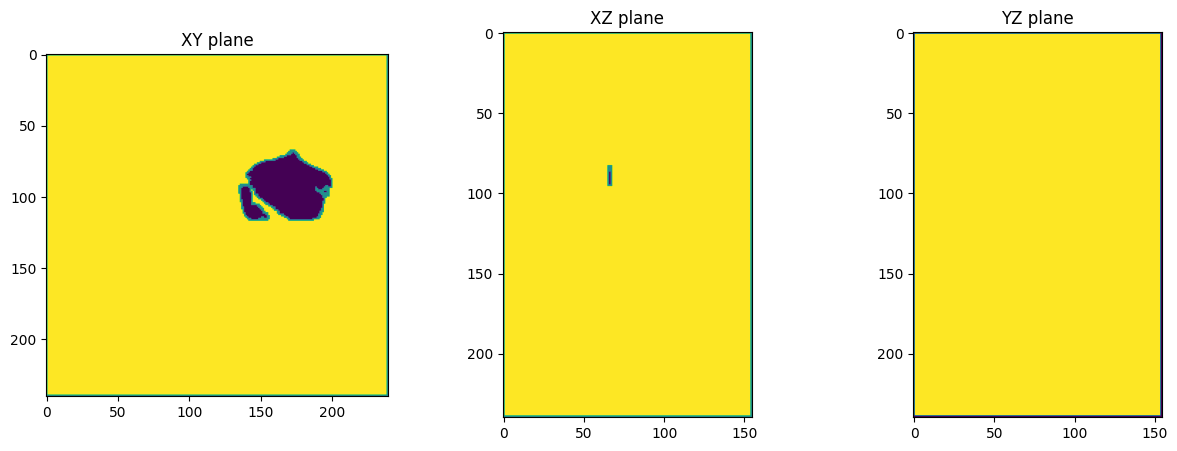

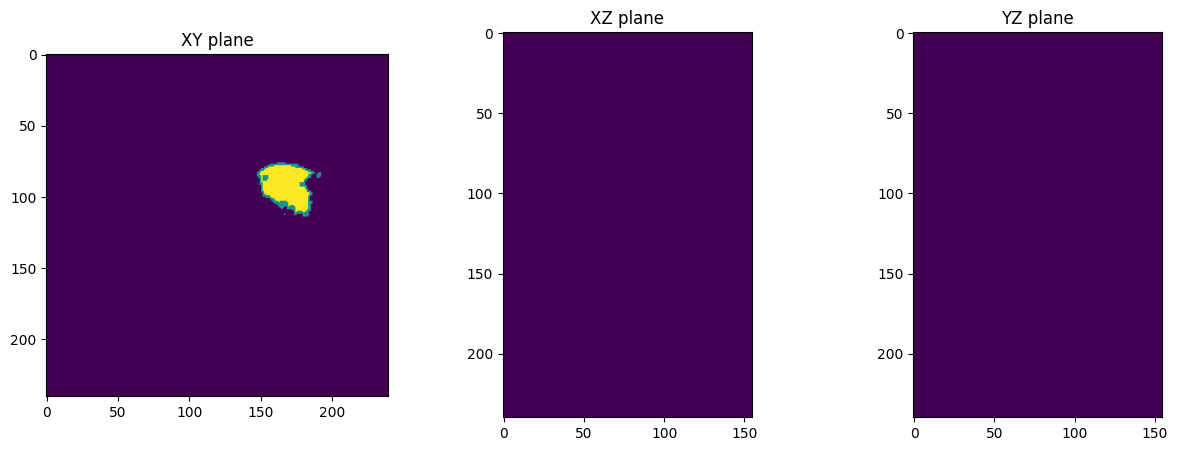

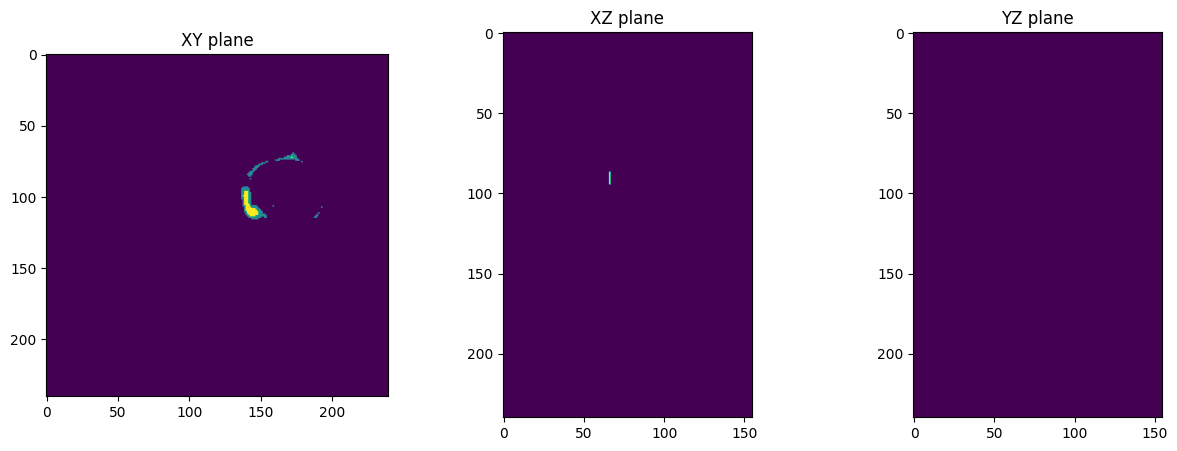

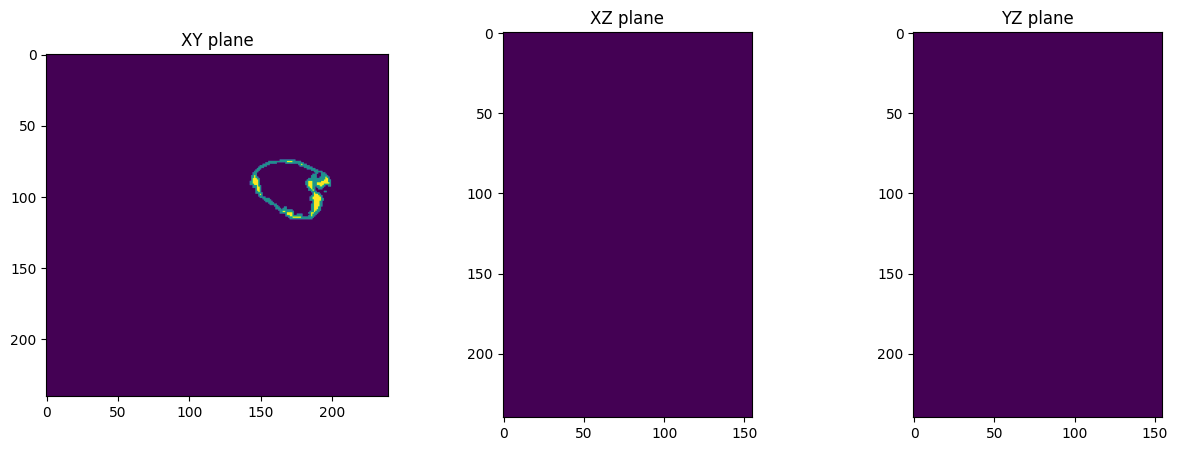

In [48]:
soft_mask = eroded_oh_seg_np + boundary_oh_seg_np*0.5
plot_all_slices(soft_mask)

## Example Cube with outstanding corners (2D)

In [23]:
example_mask = np.array([[1, 0, 1, 0, 1],
                        [0, 1, 1, 1, 0],
                        [1, 1, 1, 1, 1],
                        [0, 1, 1, 1, 0],
                        [1, 0, 1, 0, 1]])

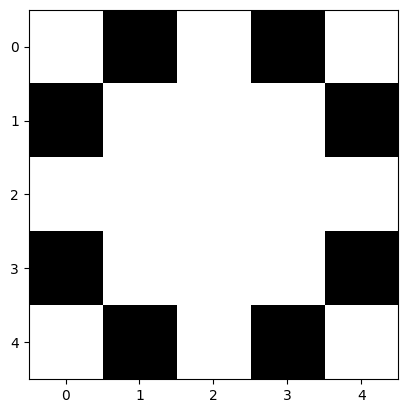

In [24]:
# plot example mask
plt.imshow(example_mask, cmap='gray')

### Pixel Connectivity 1

#### Erode with pix con 1

[[1 0 1 0 1]
 [0 1 0 1 0]
 [1 0 0 0 1]
 [0 1 0 1 0]
 [1 0 1 0 1]]


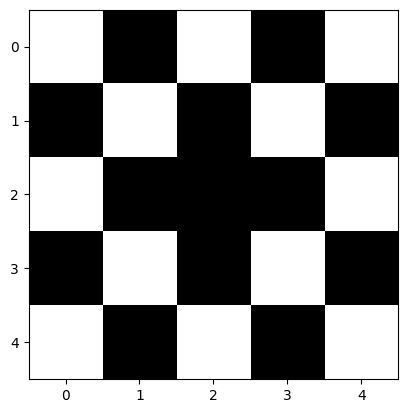

In [43]:
eroded = np_utils.np_erode_msk(example_mask, mm=1, connectivity=1)
border = example_mask - eroded
print(border)
plt.imshow(border, cmap='gray')

#### Set Border to 0.5 and create new soft mask

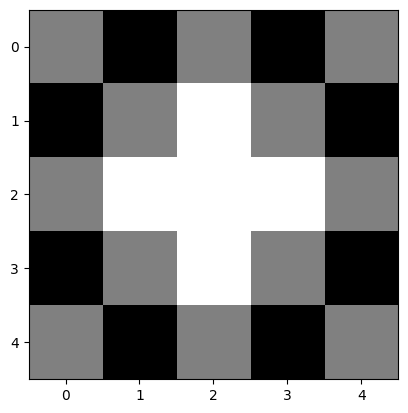

In [33]:
soft_mask = border*0.5 + eroded
plt.imshow(soft_mask, cmap='gray')

### Pixel Connectivity 3

#### Erode with pix con 3

[[1 0 1 0 1]
 [0 1 1 1 0]
 [1 1 0 1 1]
 [0 1 1 1 0]
 [1 0 1 0 1]]


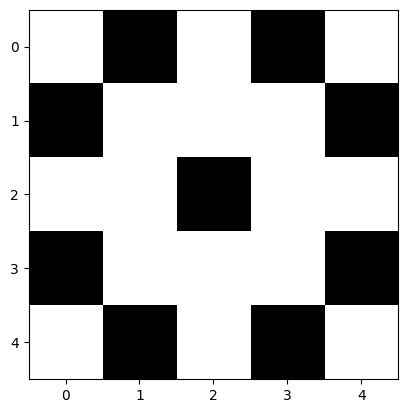

In [34]:
eroded = np_utils.np_erode_msk(example_mask, mm=1, connectivity=3)
border = example_mask - eroded
print(border)
plt.imshow(border, cmap='gray')

#### Set Border to 0.5 and create new soft mask

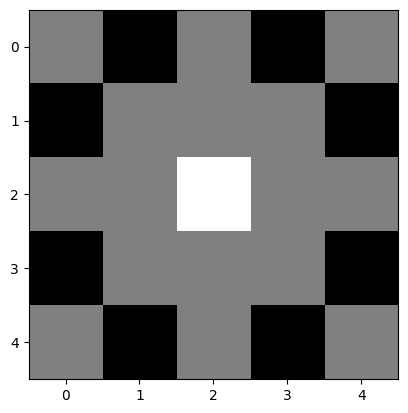

In [35]:
soft_mask = border*0.5 + eroded
plt.imshow(soft_mask, cmap='gray')

# Test Manual Softening in 3 layers

## Data Loading and Processing

### Loading and one-hot encoding

In [5]:
#Loading actual data
data_dir = '/home/student/farid_ma/dev/multiclass_softseg/MulticlassSoftSeg/data/external/ASNR-MICCAI-BraTS2023-GLI-Challenge/'
train_list = create_bids_path_list_of_dicts(data_dir + '/train', suffix = 'fnio')

# 1. load image 
sample_idx = 3
img_path = train_list[sample_idx]['t1c']
seg_path = train_list[sample_idx]['seg']

img = fnio.load(str(img_path))
seg = fnio.load(str(seg_path))

# 2. transform to torch tensors (and add channel dim to img tensor)
img_tensor = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
seg_tensor = torch.tensor(seg, dtype=torch.long)

# 3. transform seg_tensor to one hot encoding and permute the dimensions
oh_seg = F.one_hot(seg_tensor, num_classes=4)
oh_seg = oh_seg.permute(3, 0, 1, 2)

# 4. convert GT to numpy array
oh_seg_np = oh_seg.numpy()

print(f"shape of oh_seg_np: {oh_seg_np.shape}")

shape of oh_seg_np: (4, 240, 240, 155)


### Plotting og masks

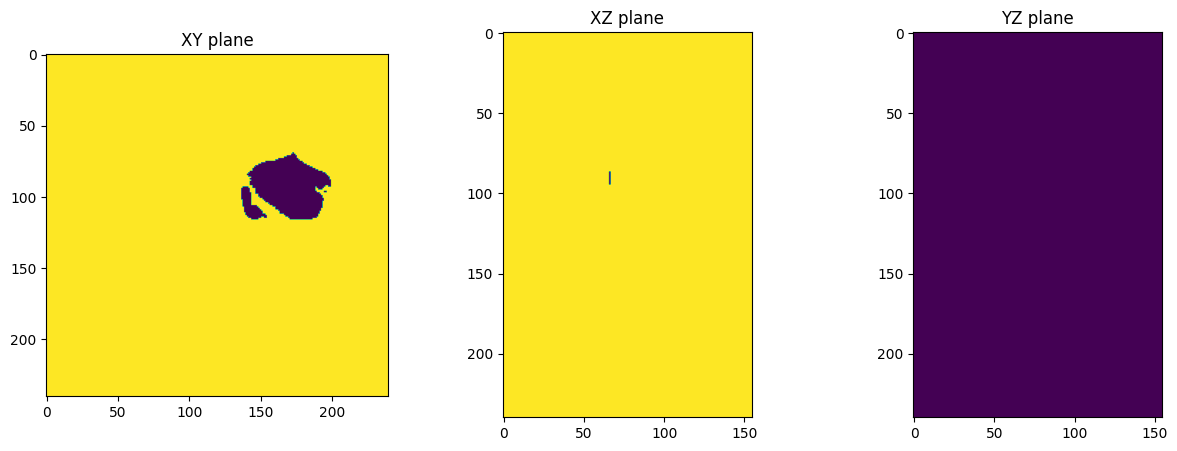

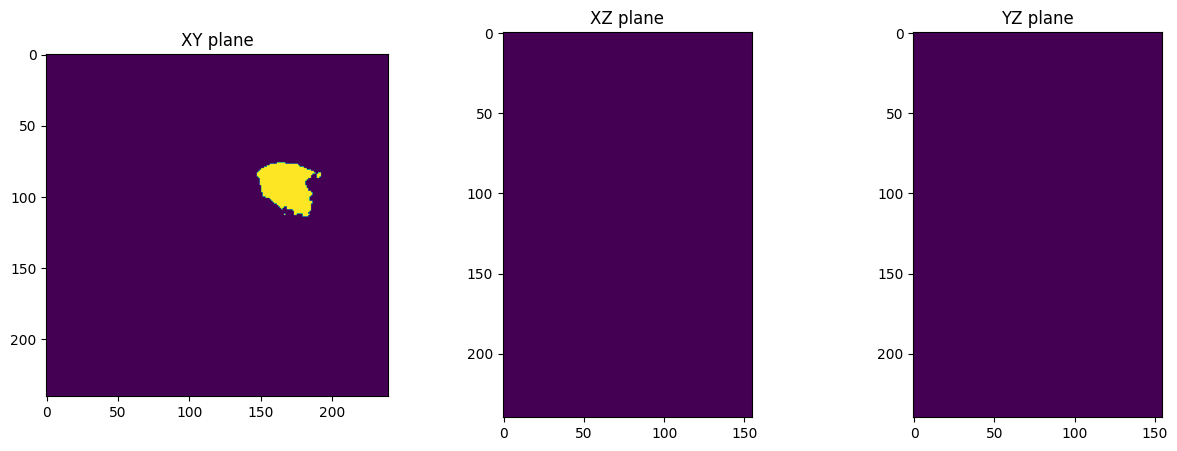

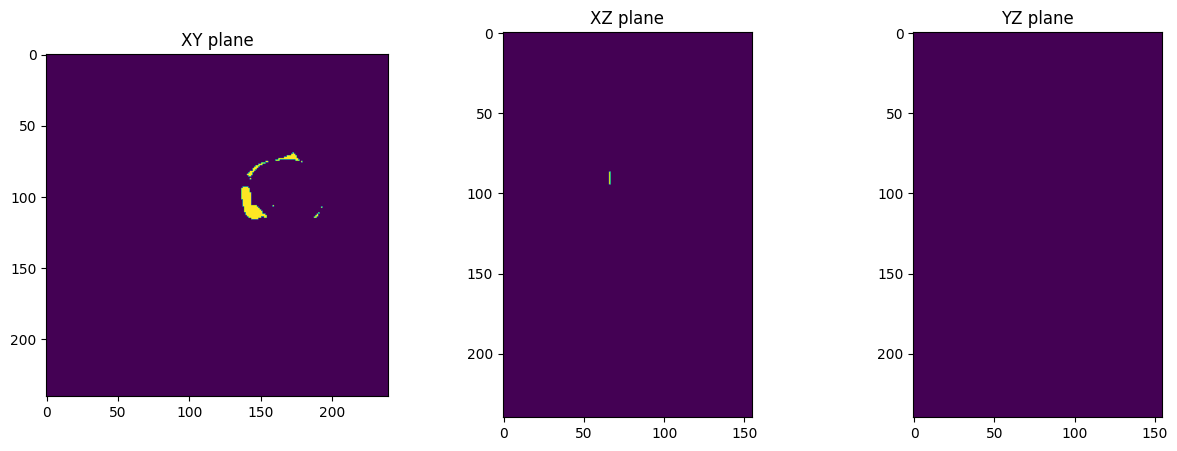

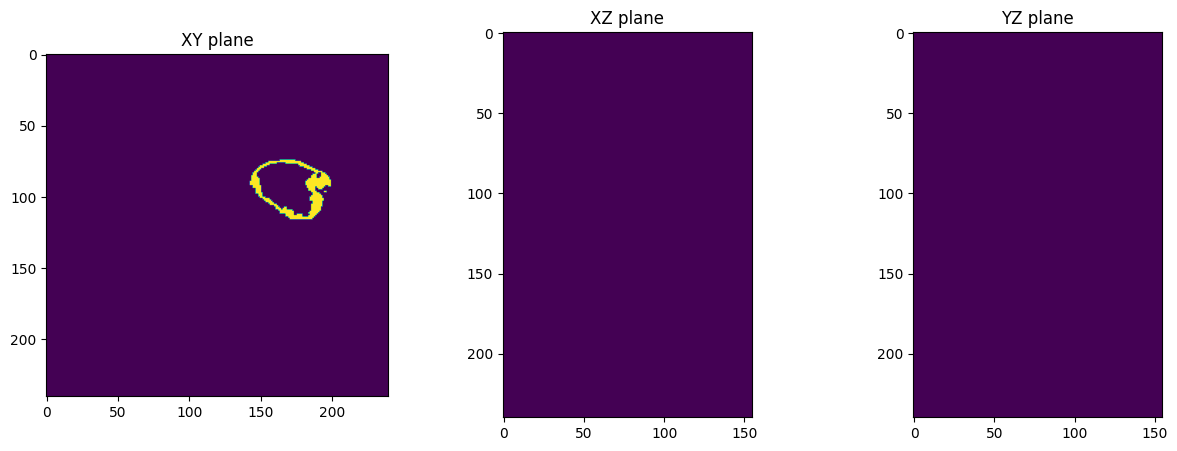

In [15]:
plot_all_slices(oh_seg_np)

### Pixel Connectivity 1

In [30]:
pixel_con = 1

#### Determining the 3 relevant layers

In [31]:
# 1. Determine the first layer outside the boundary
dilated_mask = np.zeros_like(oh_seg_np)
for channel in range(oh_seg_np.shape[0]):
    dilated_mask[channel] = np_utils.np_dilate_msk(oh_seg_np[channel], mm=1, connectivity=pixel_con)
outer_layer = dilated_mask - oh_seg_np

# 2. Determine the boundary layer
eroded_mask = np.zeros_like(oh_seg_np)
for channel in range(oh_seg_np.shape[0]):
    eroded_mask[channel] = np_utils.np_erode_msk(oh_seg_np[channel], mm=1, connectivity=pixel_con)
boundary_layer = oh_seg_np - eroded_mask

# 3. Determine the first inner layer
second_eroded_mask = np.zeros_like(oh_seg_np)
for channel in range(oh_seg_np.shape[0]):
    second_eroded_mask[channel] = np_utils.np_erode_msk(eroded_mask[channel], mm=1, connectivity=pixel_con)
inner_layer = eroded_mask - second_eroded_mask

#### Manually creating the soft mask

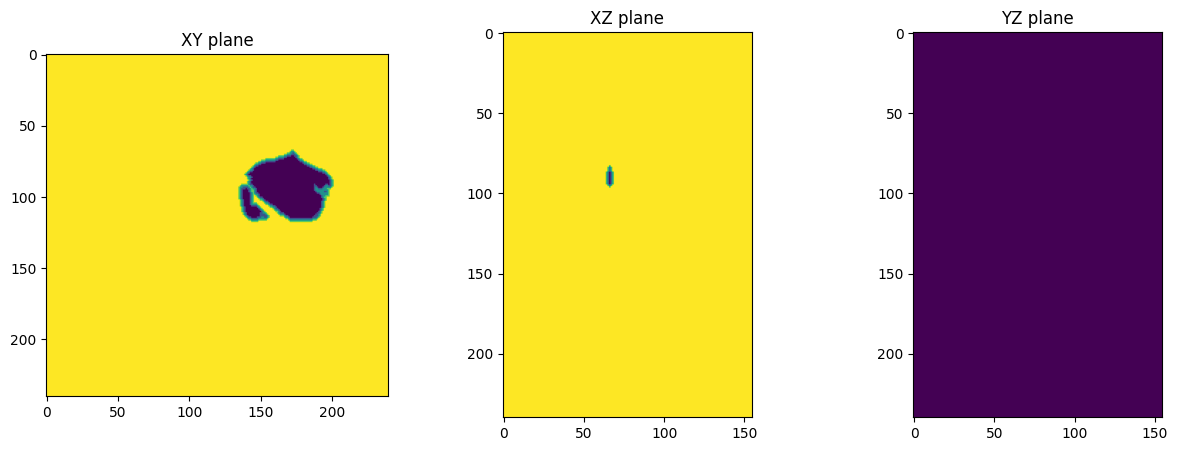

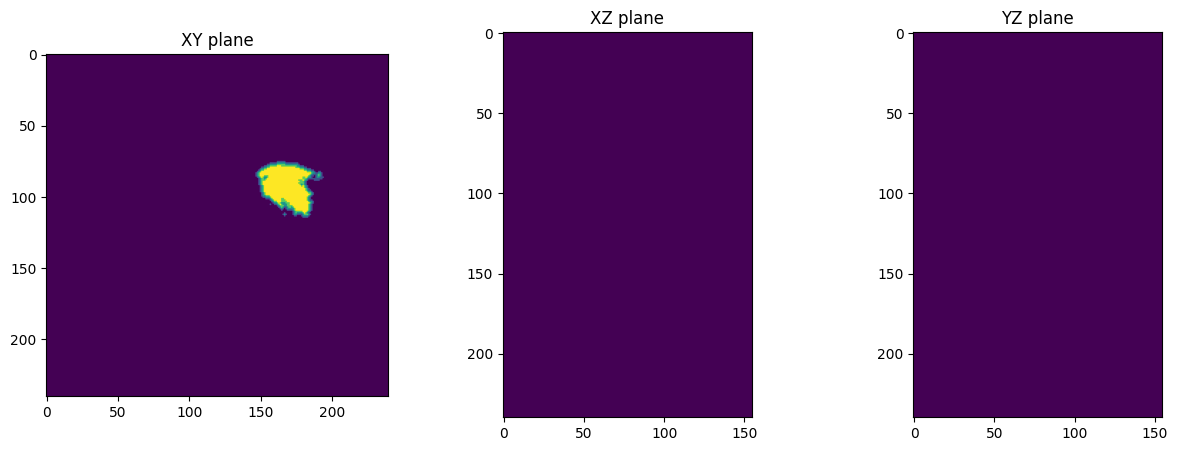

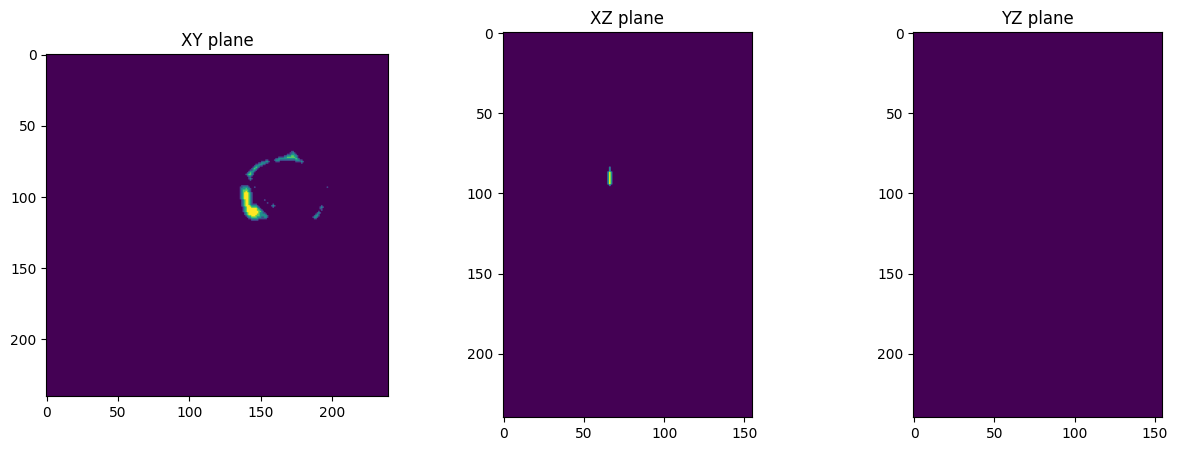

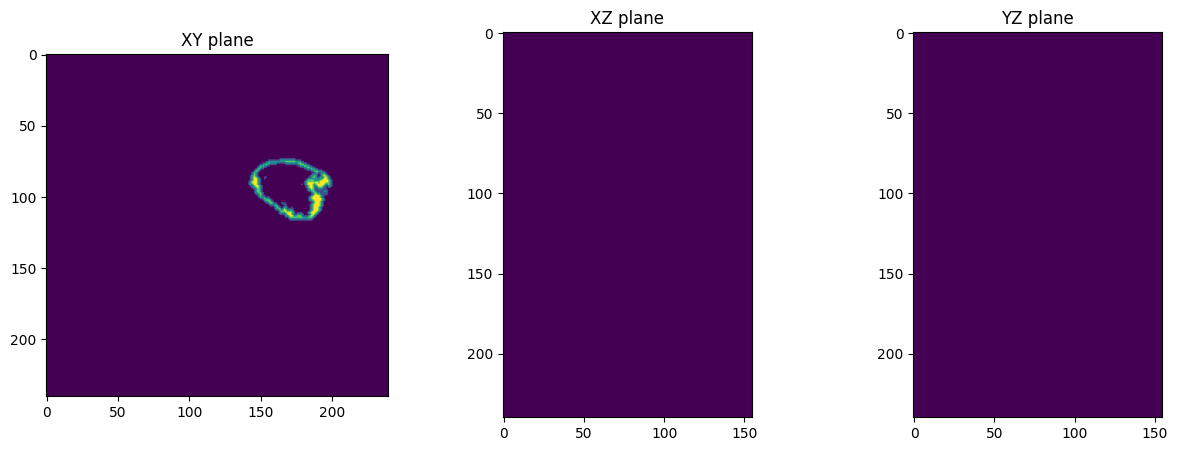

In [32]:
soft_mask = outer_layer*0.25 + boundary_layer*0.5 + inner_layer*0.75 + second_eroded_mask

# Reset the outer edges to 1 with thickness 3
# Access the first channel
channel_0 = soft_mask[0]

thickness = 2   # 2 seems to be enough
# Set the outer edges to 1 with thickness 3
channel_0[:thickness, :, :] = 1  # Top edge
channel_0[-thickness:, :, :] = 1  # Bottom edge
channel_0[:, :thickness, :] = 1  # Left edge
channel_0[:, -thickness:, :] = 1  # Right edge
channel_0[:, :, :thickness] = 1  # Front edge
channel_0[:, :, -thickness:] = 1  # Back edge

# Assign the modified channel back to the array
soft_mask[0] = channel_0

plot_all_slices(soft_mask)

### Pixel Connectivity 3

In [33]:
pixel_con = 3

#### Determining the 3 relevant layers

In [34]:
# 1. Determine the first layer outside the boundary
dilated_mask = np.zeros_like(oh_seg_np)
for channel in range(oh_seg_np.shape[0]):
    dilated_mask[channel] = np_utils.np_dilate_msk(oh_seg_np[channel], mm=1, connectivity=pixel_con)
outer_layer = dilated_mask - oh_seg_np

# 2. Determine the boundary layer
eroded_mask = np.zeros_like(oh_seg_np)
for channel in range(oh_seg_np.shape[0]):
    eroded_mask[channel] = np_utils.np_erode_msk(oh_seg_np[channel], mm=1, connectivity=pixel_con)
boundary_layer = oh_seg_np - eroded_mask

# 3. Determine the first inner layer
second_eroded_mask = np.zeros_like(oh_seg_np)
for channel in range(oh_seg_np.shape[0]):
    second_eroded_mask[channel] = np_utils.np_erode_msk(eroded_mask[channel], mm=1, connectivity=pixel_con)
inner_layer = eroded_mask - second_eroded_mask

#### Manually creating the soft mask

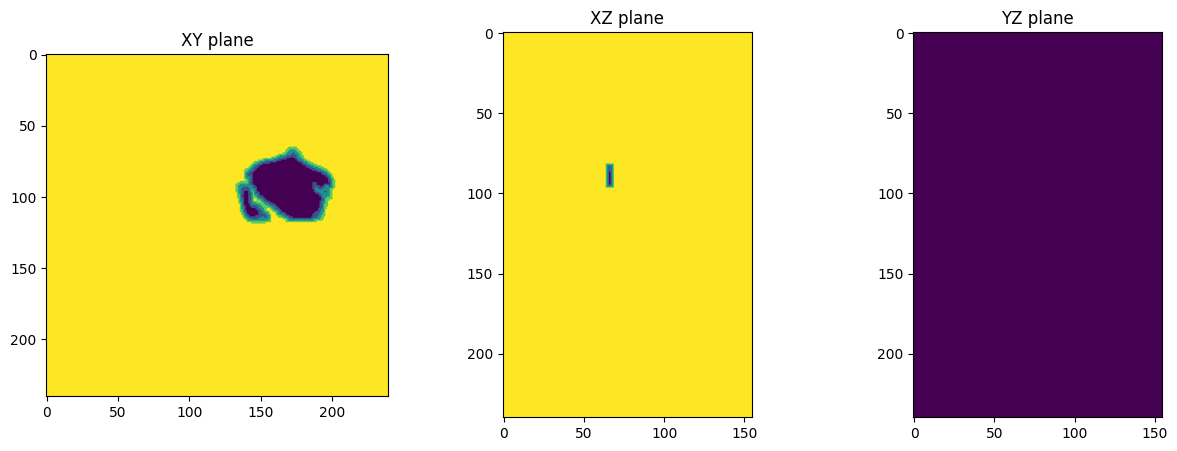

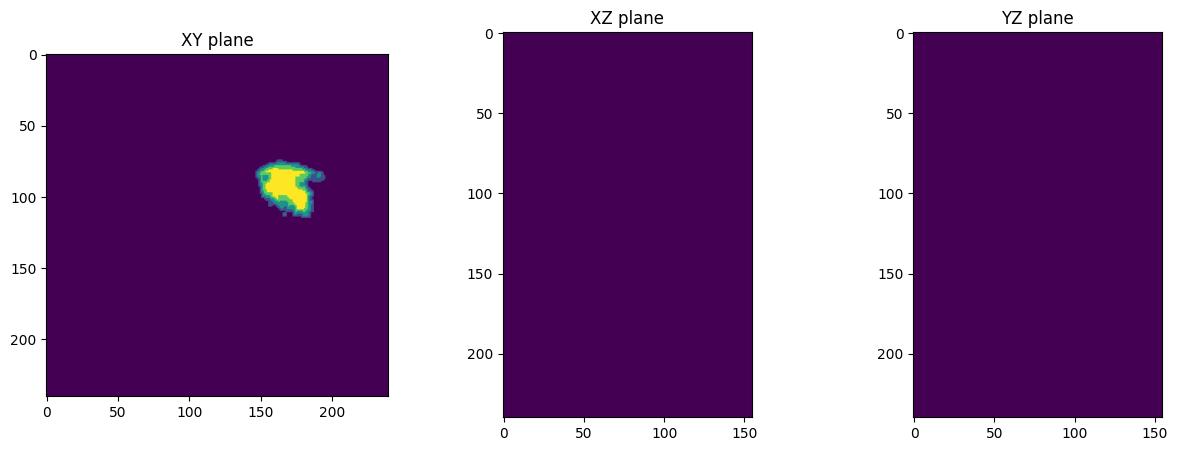

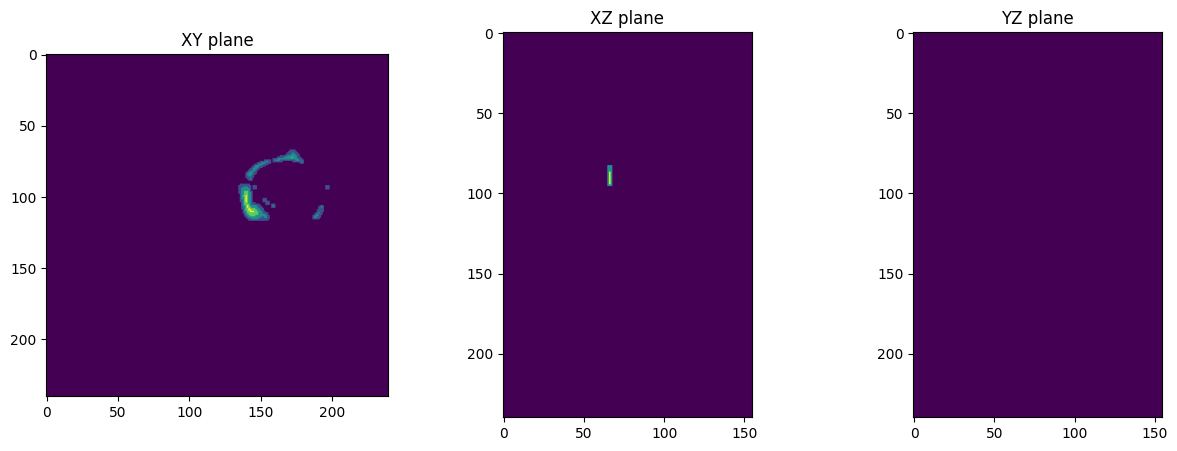

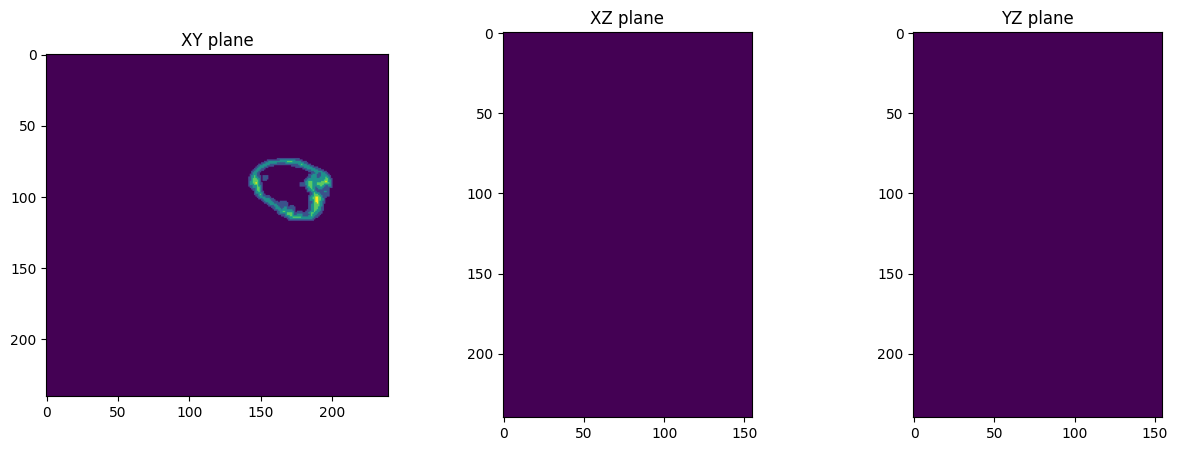

In [35]:
soft_mask_con3 = outer_layer*0.25 + boundary_layer*0.5 + inner_layer*0.75 + second_eroded_mask

# Reset the outer edges to 1 with thickness 3
# Access the first channel
channel_0 = soft_mask_con3[0]

thickness = 2   # 2 seems to be enough
# Set the outer edges to 1 with thickness 3
channel_0[:thickness, :, :] = 1  # Top edge
channel_0[-thickness:, :, :] = 1  # Bottom edge
channel_0[:, :thickness, :] = 1  # Left edge
channel_0[:, -thickness:, :] = 1  # Right edge
channel_0[:, :, :thickness] = 1  # Front edge
channel_0[:, :, -thickness:] = 1  # Back edge

# Assign the modified channel back to the array
soft_mask_con3[0] = channel_0

plot_all_slices(soft_mask_con3)

### Difference between pix con 1 and 3

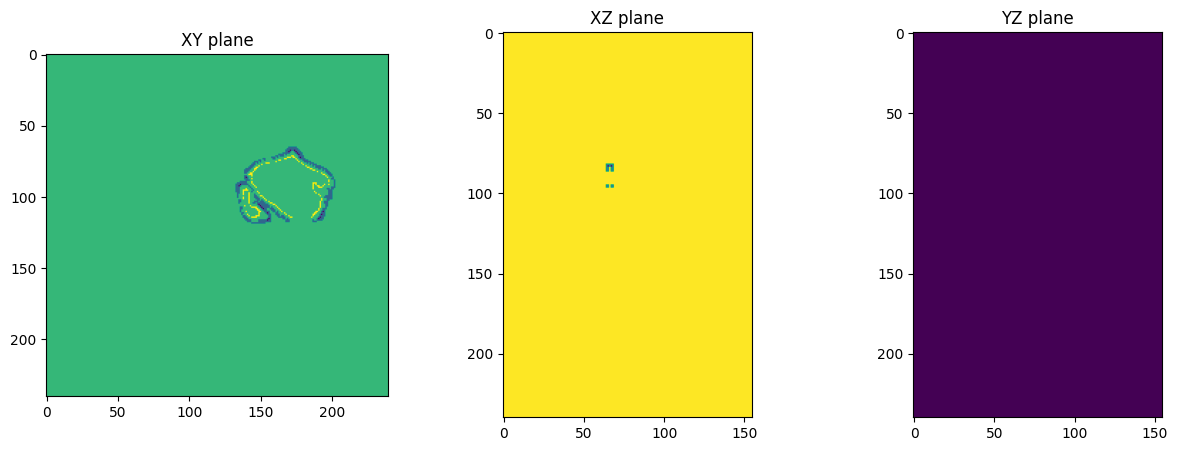

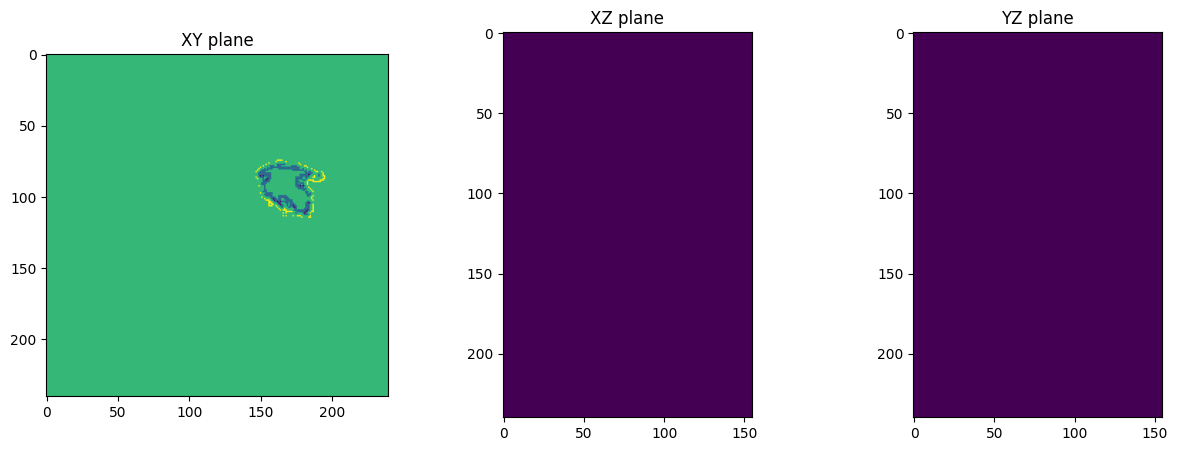

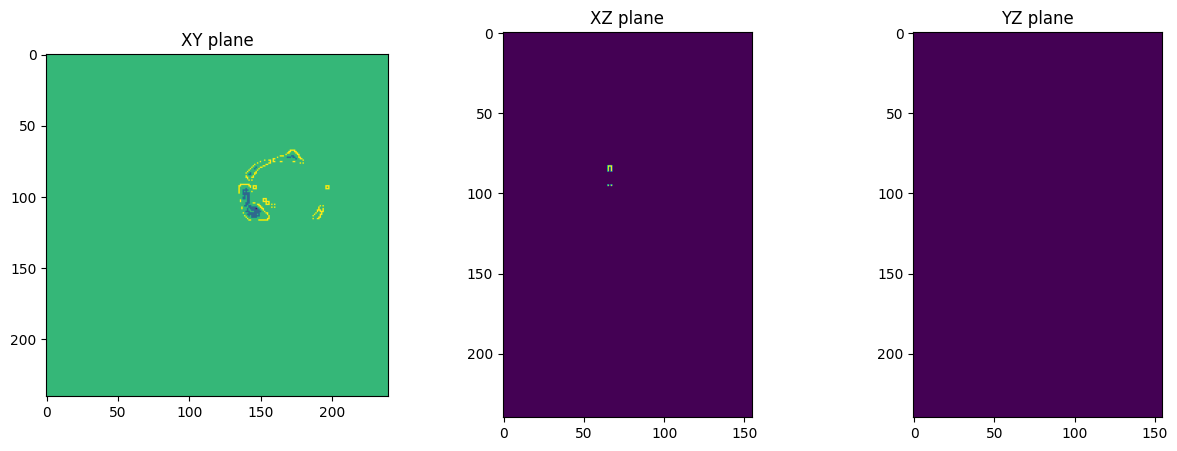

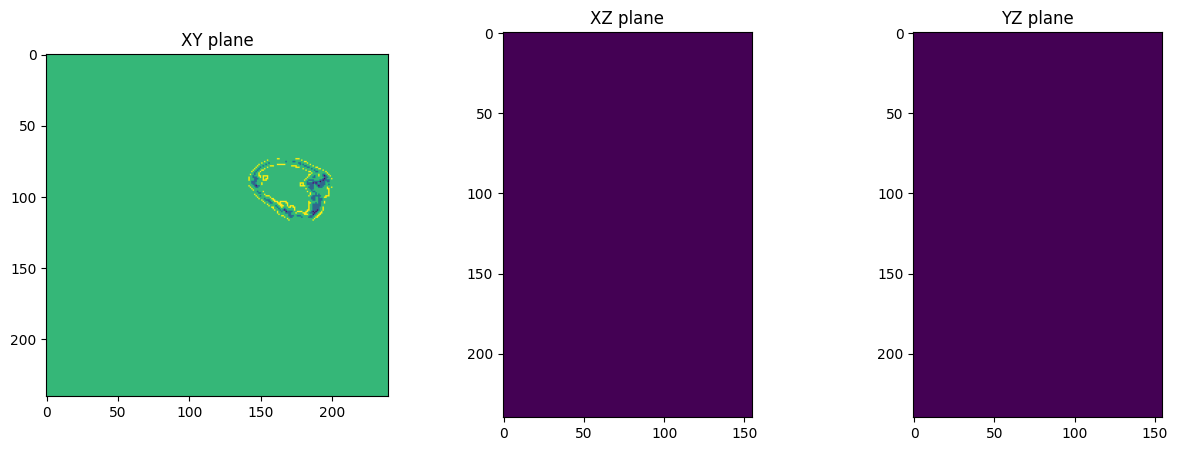

In [36]:
difference = soft_mask_con3 - soft_mask
plot_all_slices(difference) 